## Only first epinephrine analysis

## Filtering patients with only one epi and valid epi for multiple epi

In [4]:
import pandas as pd

# Load data from your Excel file
df = pd.read_excel('filtered_etco2_with_epi_in_range_minus_3min_plus_5min_final_multiple_epitime.xlsx', sheet_name='Sheet1')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

# Sort by patientId and start time to ensure proper sequencing
df = df.sort_values(by=['patientId', 'start'])

# Initialize a counter for patients with multiple epi_time records
multiple_epi_count = 0

# Function to find the first valid epi_time for each patient based on etco2 association
def find_valid_epi_time(group):
    global multiple_epi_count
    epi_rows = group[group['epi_time'].notna()]

    # If there is only one epi_time, retain it as it is
    if len(epi_rows) == 1:
        return group  # Return the entire group (all rows for the patient)

    # If there are multiple epi_time entries, increment the count
    multiple_epi_count += 1

    # Check for valid etco2 values within the range of plus or minus 5 minutes
    for idx, epi_row in epi_rows.iterrows():
        epi_time = epi_row['epi_time']
        
        # Check for etco2 values within 5 minutes before or after epi_time
        etco2_range = group[(group['start'] >= epi_time - pd.Timedelta(minutes=5)) & 
                            (group['start'] <= epi_time + pd.Timedelta(minutes=5))]
        
        # If there are more than 4 valid etco2 values in this range, accept this epi_time
        if etco2_range['etco2'].count() > 4:
            group['epi_time'] = pd.NaT  # Reset all epi_time values to NaT (blank)
            group.loc[idx, 'epi_time'] = epi_time  # Keep only this row's epi_time as valid
            return group

    # If no valid epi_time is found, set all epi_time values to NaT (blank)
    group['epi_time'] = pd.NaT
    return group

# Apply the function for each patientId and retain the full record but adjust the epi_time
df_valid_epi_time = df.groupby('patientId').apply(find_valid_epi_time).reset_index(drop=True)

# For patients with only one epi_time, keep them as they are (even if valid or not)
df_one_epi_time = df[df['epi_time'].notna()].groupby('patientId').filter(lambda group: len(group) == 1)

# Combine the data with valid first epi_times and those with only one epi_time
df_final = pd.concat([df_valid_epi_time, df_one_epi_time]).drop_duplicates(subset=['patientId', 'start'])

# Save the filtered data to a new Excel file
output_filename = 'filtered_data_with_valid_epi_time_full_records_final.xlsx'
df_final.to_excel(output_filename, index=False)

# Print out the count of patients with multiple epi_time records
print(f"Number of patients with multiple epi_time records: {multiple_epi_count}")
print(f"Filtered data saved to {output_filename}")


Number of patients with multiple epi_time records: 200
Filtered data saved to filtered_data_with_valid_epi_time_full_records_final.xlsx


In [4]:
import pandas as pd

# Load your Excel file (adjust the path as needed)
file_path = 'merged_epi_etco2_work.xlsx'
df = pd.read_excel(file_path)


# Define the columns that represent epinephrine events
epi_columns = ['epivasoalntm',
'epi1', 'epi2', 'epi3', 'epi4', 'epi5', 'epi6', 'epi7', 'epi8', 'epi9', 'epi10']

# Count the non-null values (i.e., epinephrine events) in the epi columns for each caseId
df['epi_count'] = df[epi_columns].notnull().sum(axis=1)

# Save the updated DataFrame to a new Excel file
output_file = 'epinephrine_count_output.xlsx'
df.to_excel(output_file, index=False)

print(f"New Excel file with epinephrine counts saved as {output_file}")

New Excel file with epinephrine counts saved as epinephrine_count_output.xlsx


In [16]:
import pandas as pd

# Load data from your Excel file
df = pd.read_excel('filtered_etco2_with_epi_in_range_minus_3min_plus_5min_final_multiple_epitime.xlsx', sheet_name='Sheet1')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

# Sort by patientId and start time to ensure proper sequencing
df = df.sort_values(by=['patientId', 'start'])

# Initialize a counter for patients with multiple epi_time records
multiple_epi_count = 0

# Function to find the first, second, and third valid epi_time for each patient based on etco2 association
def find_valid_epi_times(group):
    global multiple_epi_count
    epi_rows = group[group['epi_time'].notna()]

    # If there is only one epi_time, retain it as it is
    if len(epi_rows) == 1:
        return group  # Return the entire group (all rows for the patient)

    # If there are multiple epi_time entries, increment the count
    multiple_epi_count += 1

    valid_episodes = []  # List to hold valid epi times

    # Check for valid etco2 values within the range of plus or minus 5 minutes for each epi_time
    for idx, epi_row in epi_rows.iterrows():
        epi_time = epi_row['epi_time']
        
        # Check for etco2 values within 5 minutes before or after epi_time
        etco2_range = group[(group['start'] >= epi_time - pd.Timedelta(minutes=5)) & 
                            (group['start'] <= epi_time + pd.Timedelta(minutes=5))]
        
        # If there are more than 4 valid etco2 values in this range, accept this epi_time
        if etco2_range['etco2'].count() > 4:
            valid_episodes.append((idx, epi_time))  # Store the index and epi_time

        # Keep only the first, second, and third valid epi times
        if len(valid_episodes) == 3:
            break

    # Reset all epi_time values to NaT (null)
    group['epi_time'] = pd.NaT
    
    # Assign the first, second, and third valid epi_time back to the corresponding rows
    for idx, valid_epi_time in valid_episodes:
        group.loc[idx, 'epi_time'] = valid_epi_time

    return group

# Apply the function for each patientId and retain the full record but adjust the epi_time
df_valid_epi_times = df.groupby('patientId').apply(find_valid_epi_times).reset_index(drop=True)

# For patients with only one epi_time, keep them as they are (even if valid or not)
df_one_epi_time = df[df['epi_time'].notna()].groupby('patientId').filter(lambda group: len(group) == 1)

# Combine the data with valid first, second, and third epi_times and those with only one epi_time
df_final = pd.concat([df_valid_epi_times, df_one_epi_time]).drop_duplicates(subset=['patientId', 'start'])

# Save the filtered data to a new Excel file
output_filename = 'filtered_data_with_first_three_valid_epi_times_full_records_final.xlsx'
df_final.to_excel(output_filename, index=False)

# Print out the count of patients with multiple epi_time records
print(f"Number of patients with multiple epi_time records: {multiple_epi_count}")
print(f"Filtered data saved to {output_filename}")


Number of patients with multiple epi_time records: 200
Filtered data saved to filtered_data_with_first_three_valid_epi_times_full_records_final.xlsx


In [20]:
import pandas as pd

# Load data from your Excel file
df = pd.read_excel('filtered_data_with_first_three_valid_epi_times_full_records_final.xlsx')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

# Sort by patientId and start time to ensure proper sequencing
df = df.sort_values(by=['patientId', 'start'])

# Step 1: Separate into single epinephrine cases and multiple epinephrine cases
df_single_epi = df.groupby('patientId').filter(lambda g: g['epi_time'].nunique() == 1)  # Single epinephrine
df_multi_epi = df.groupby('patientId').filter(lambda g: g['epi_time'].nunique() > 1)  # Multiple epinephrines

# Save the full data (not cropped) for both single and multiple epinephrine cases
df_single_epi.to_excel('Single_Epi_Cases_Full.xlsx', index=False)
df_multi_epi.to_excel('Multi_Epi_Cases_Full.xlsx', index=False)

print(f"Single epinephrine cases saved to 'Single_Epi_Cases_Full.xlsx'")
print(f"Multiple epinephrine cases saved to 'Multi_Epi_Cases_Full.xlsx'")


Single epinephrine cases saved to 'Single_Epi_Cases_Full.xlsx'
Multiple epinephrine cases saved to 'Multi_Epi_Cases_Full.xlsx'


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define folders for saving plots
output_folder_single = 'ETCO2_Plots_Single_Epi'
output_folder_multi = 'ETCO2_Plots_Multi_Epi'

# Create output folders if they don't exist
if not os.path.exists(output_folder_single):
    os.makedirs(output_folder_single)
if not os.path.exists(output_folder_multi):
    os.makedirs(output_folder_multi)

# Function to plot ETCO₂ values with cropping for display
def plot_etco2_values(df, output_folder):
    for patient_id, group in df.groupby('patientId'):
        # Find the first epinephrine time for cropping
        first_epi_time = group['epi_time'].min()
        
        # Crop data for the plot: include 5 minutes before the first epinephrine and all values after
        group_plot = group[group['start'] >= first_epi_time - pd.Timedelta(minutes=5)]
        
        # Plot ETCO₂ values
        plt.figure(figsize=(10, 6))
        plt.plot(group_plot['start'], group_plot['etco2'], label='ETCO₂', marker='o')

        # Mark epinephrine times (for multi-epi cases, all epi_times will be plotted)
        for _, row in group.iterrows():
            if pd.notna(row['epi_time']):
                plt.axvline(x=row['epi_time'], color='r', linestyle='--', label='Epinephrine Time', lw=2)

        plt.title(f'Patient {patient_id} - ETCO₂ Trend')
        plt.xlabel('Time')
        plt.ylabel('ETCO₂ Value')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)

        # Save plot to the respective folder
        plot_filename = os.path.join(output_folder, f'Patient_{patient_id}_ETCO2_Trend.png')
        plt.savefig(plot_filename)
        plt.close()

    print(f"Patient ETCO₂ trend plots saved in {output_folder}")

# Step 2: Read the Excel files and plot data for each category

# For single epinephrine cases
df_single_epi = pd.read_excel('Single_Epi_Cases_Full.xlsx')
plot_etco2_values(df_single_epi, output_folder_single)

# For multiple epinephrine cases
df_multi_epi = pd.read_excel('Multi_Epi_Cases_Full.xlsx')
plot_etco2_values(df_multi_epi, output_folder_multi)


Patient ETCO₂ trend plots saved in ETCO2_Plots_Single_Epi
Patient ETCO₂ trend plots saved in ETCO2_Plots_Multi_Epi


In [24]:
single_epi_unique_patients = df_single_epi['patientId'].nunique()
multi_epi_unique_patients = df_multi_epi['patientId'].nunique()

(single_epi_unique_patients, multi_epi_unique_patients)

(510, 139)

Number of ROSC patients: 139
Number of Non-ROSC patients: 371

Averages for ROSC group:
t_lag                   2.058633
time_to_peak            4.332014
t_duration              6.057554
proportional_change    78.840426
dtype: float64

Averages for Non-ROSC group:
t_lag                   2.010406
time_to_peak            3.274956
t_duration              3.903439
proportional_change    51.516757
dtype: float64
Results have been saved to etco2_tlag_tpeak_tduration_analysis_rosc_non_rosc.xlsx


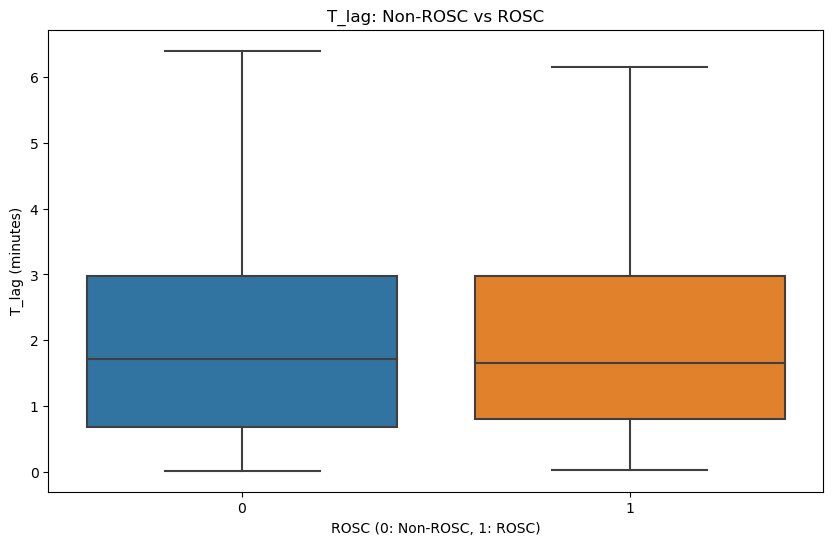

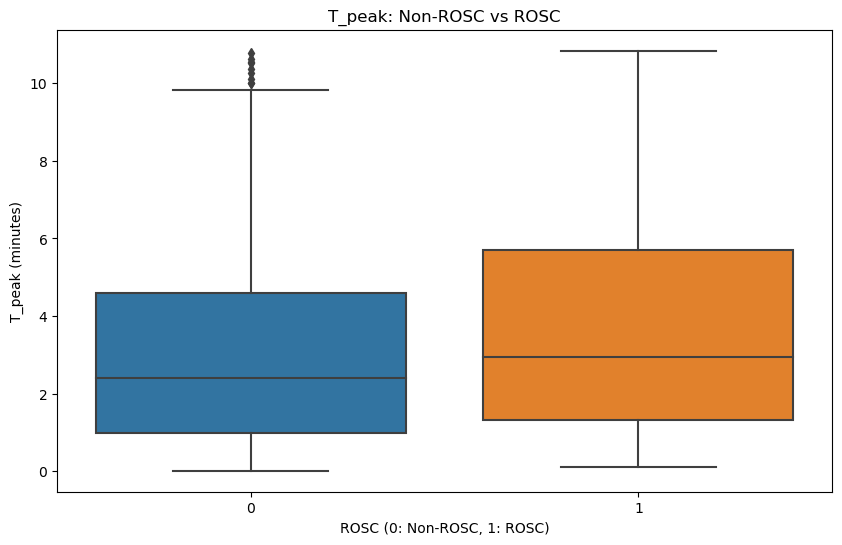

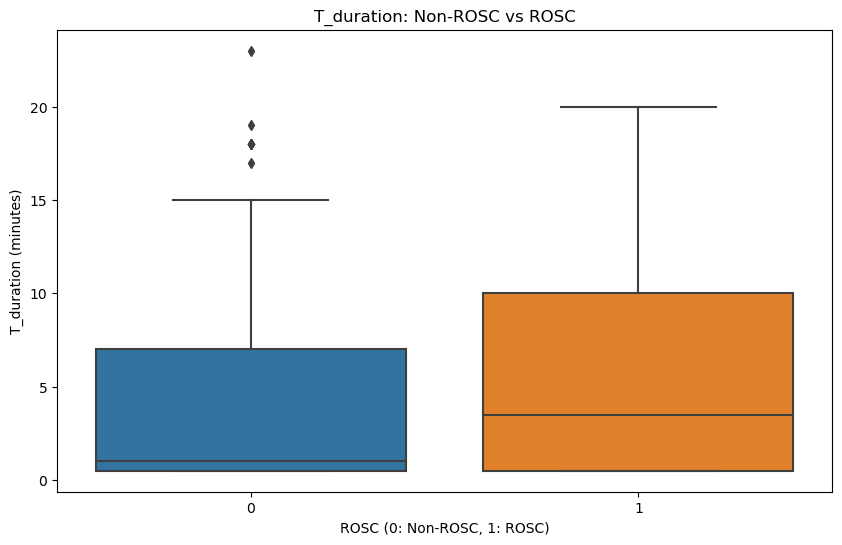

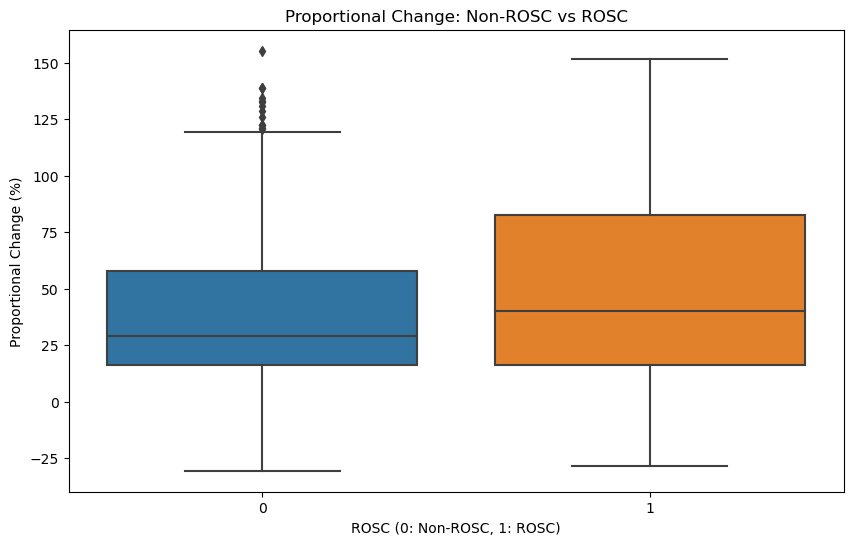


Summary Statistics for ROSC group:
            t_lag  time_to_peak  t_duration  proportional_change
count  139.000000    139.000000  139.000000           129.000000
mean     2.058633      4.332014    6.057554            78.840426
std      1.547460      3.721638    6.198726            98.521480
min      0.033333      0.116667    0.500000           -28.580934
25%      0.808333      1.358333    0.500000            17.569506
50%      1.650000      3.316667    4.000000            50.548077
75%      2.983333      6.175000   10.000000           105.924951
max      6.150000     15.750000   30.000000           707.552326
median: 't_lag                   1.650000
time_to_peak            3.316667
t_duration              4.000000
proportional_change    50.548077
dtype: float64

Summary Statistics for Non-ROSC group:
            t_lag  time_to_peak  t_duration  proportional_change
count  378.000000    378.000000  378.000000           353.000000
mean     2.010406      3.274956    3.903439          

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Load data from your Excel file
df = pd.read_excel('Single_Epi_Cases_Full.xlsx')  # Replace with your actual file
rosc_df = pd.read_excel('filtered_etco2_with_epi_in_range_minus_3min_plus_5min_final_multiple_epitime.xlsx', sheet_name='Sheet2')

# Merge ROSC data with the ETCO₂ data on patientId
df = df.merge(rosc_df[['caseid', 'mnrosc']], left_on='patientId', right_on='caseid', how='left')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

output_folder = 'ETCO2_Plots_Analysis_Corrected_v3'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Sort by patientId and start time
df = df.sort_values(by=['patientId', 'start'])

# Function to fill missing baseline etco2 using lowest value within ±3 minutes
def fill_missing_baseline(group):
    for idx, row in group.iterrows():
        if pd.isna(row['etco2']):
            epi_time = row['epi_time']
            time_window = group[(group['start'] >= epi_time - pd.Timedelta(minutes=3)) & 
                                (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
            if not time_window['etco2'].isna().all():
                row['etco2'] = time_window['etco2'].min()  # Use the lowest ETCO₂ value
            group.at[idx, 'etco2'] = row['etco2']
    return group

# Function to analyze ETCO₂ response for each patient
def analyze_etco2_response(group):
    results = []
    epi_rows = group[group['epi_time'].notna()]
    
    for _, epi_row in epi_rows.iterrows():
        epi_time = epi_row['epi_time']
        baseline_etco2 = epi_row['etco2']
        
        if pd.isna(baseline_etco2):
            group = fill_missing_baseline(group)
            baseline_etco2 = group.loc[group['epi_time'] == epi_time, 'etco2'].values[0]  # Re-fetch the filled baseline

        post_epi_10min = group[(group['start'] > epi_time) & (group['start'] <= epi_time + pd.Timedelta(minutes=10))]

        t_lag = None
        for idx, row in post_epi_10min.iterrows():
            if row['etco2'] > baseline_etco2 * 1.15:
                t_lag = (row['start'] - epi_time).total_seconds() / 60
                break

        if t_lag is None:
            post_3min = group[(group['start'] > epi_time) & (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
            if not post_3min['etco2'].isna().all():
                baseline_etco2 = post_3min['etco2'].min()
                for idx, row in post_epi_10min.iterrows():
                    if row['etco2'] > baseline_etco2 * 1.15:
                        t_lag = (row['start'] - epi_time).total_seconds() / 60
                        break
        

        t_duration = None
        peak_etco2 = None
        time_to_peak = None
        if t_lag is not None and t_lag <= 6.5:
            t_lag_time = epi_time + pd.Timedelta(minutes=t_lag)
            post_lag = group[group['start'] >= t_lag_time]

            t_duration = None
            consecutive_count = 0
            for idx in range(len(post_lag)):
                if post_lag.iloc[idx]['etco2'] < baseline_etco2 * 1.15:
                    consecutive_count += 1
                else:
                    consecutive_count = 0

                if consecutive_count == 2:
                    t_duration = (post_lag.iloc[idx - 1]['start'] - t_lag_time).total_seconds() / 60
                    break

            if t_duration is None:
                t_duration = 10
                '''last_non_null_etco2 = post_lag[post_lag['etco2'].notna()].iloc[-1]  # Find the last non-null ETCO₂ value
                if not last_non_null_etco2.empty:
                        t_duration = (last_non_null_etco2['start'] - t_lag_time).total_seconds() / 60'''
            
            etco2_during_duration = post_lag[(post_lag['start'] <= t_lag_time + pd.Timedelta(minutes=t_duration))]

            if not etco2_during_duration.empty:
                peak_etco2 = etco2_during_duration['etco2'].max()
                peak_row = etco2_during_duration[etco2_during_duration['etco2'] == peak_etco2]
                if not peak_row.empty:
                    peak_row = peak_row.iloc[0]
                    if peak_row['etco2'] == post_lag.iloc[0]['etco2']:
                        time_to_peak = t_lag
                    else:
                        time_to_peak = (peak_row['start'] - epi_time).total_seconds() / 60

        if t_lag is None or (t_lag is not None and (time_to_peak is None or t_duration is None)):
            post_epi_5min = group[(group['start'] > epi_time) & (group['start'] <= epi_time + pd.Timedelta(minutes=5))]
            if not post_epi_5min.empty:
                peak_etco2 = post_epi_5min['etco2'].max()
                peak_row = post_epi_5min[post_epi_5min['etco2'] == peak_etco2]
                if not peak_row.empty:
                    peak_row = peak_row.iloc[0]
                    t_lag = (peak_row['start'] - epi_time).total_seconds() / 60
                    time_to_peak = t_lag
                    t_duration = 0.5

        

        delta_etco2_peak = peak_etco2 - baseline_etco2 if peak_etco2 else None
        proportional_change = (delta_etco2_peak / baseline_etco2) * 100 if baseline_etco2 and delta_etco2_peak else None

    

        results.append({
            'patientId': epi_row['patientId'], 
            'epi_time': epi_time, 
            'baseline_etco2': baseline_etco2,
            'peak_etco2': peak_etco2,
            'delta_etco2_peak': delta_etco2_peak,
            'proportional_change': proportional_change,
            't_lag': t_lag,
            'time_to_peak': time_to_peak,
            't_duration': t_duration,
            'rosc': epi_row['mnrosc']  # Add ROSC/Non-ROSC label
        })
        
    return pd.DataFrame(results)

# Group by patientId and analyze the ETCO₂ changes for all patients
results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)

# Split the data into ROSC and Non-ROSC groups
rosc_results = results[results['rosc'] == 1]
non_rosc_results = results[results['rosc'] == 0]

# Count ROSC and Non-ROSC patients
rosc_count = rosc_results['patientId'].nunique()
non_rosc_count = non_rosc_results['patientId'].nunique()

print(f"Number of ROSC patients: {rosc_count}")
print(f"Number of Non-ROSC patients: {non_rosc_count}")

# Calculate averages
rosc_avg = rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].mean()
non_rosc_avg = non_rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].mean()


# Calculate averages
rosc_median = rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].median()
non_rosc_median = non_rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].median()


print("\nAverages for ROSC group:")
print(rosc_avg)

print("\nAverages for Non-ROSC group:")
print(non_rosc_avg)

# Save the results to Excel
output_filename = 'etco2_tlag_tpeak_tduration_analysis_rosc_non_rosc.xlsx'
results.to_excel(output_filename, index=False)
print(f"Results have been saved to {output_filename}")


# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each metric
results_cleaned_t_lag = remove_outliers(results, 't_lag')
results_cleaned_time_to_peak = remove_outliers(results, 'time_to_peak')
results_cleaned_t_duration = remove_outliers(results, 't_duration')
results_cleaned_proportional_change = remove_outliers(results, 'proportional_change')

# Box plot for T_lag without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='rosc', y='t_lag', data=results_cleaned_t_lag)
plt.title('T_lag: Non-ROSC vs ROSC')
plt.xlabel('ROSC (0: Non-ROSC, 1: ROSC)')
plt.ylabel('T_lag (minutes)')
plt.show()

# Box plot for time_to_peak without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='rosc', y='time_to_peak', data=results_cleaned_time_to_peak)
plt.title('T_peak: Non-ROSC vs ROSC')
plt.xlabel('ROSC (0: Non-ROSC, 1: ROSC)')
plt.ylabel('T_peak (minutes)')
plt.show()

# Box plot for T_duration without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='rosc', y='t_duration', data=results_cleaned_t_duration)
plt.title('T_duration: Non-ROSC vs ROSC')
plt.xlabel('ROSC (0: Non-ROSC, 1: ROSC)')
plt.ylabel('T_duration (minutes)',)
plt.show()

# Box plot for proportional_change without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='rosc', y='proportional_change', data=results_cleaned_proportional_change)
plt.title('Proportional Change: Non-ROSC vs ROSC')
plt.xlabel('ROSC (0: Non-ROSC, 1: ROSC)')
plt.ylabel('Proportional Change (%)')
plt.show()

# Summary statistics for ROSC and Non-ROSC
rosc_summary = rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].describe()
non_rosc_summary = non_rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].describe()

print("\nSummary Statistics for ROSC group:")
print(rosc_summary)
print(f"median: '{rosc_median}")

print("\nSummary Statistics for Non-ROSC group:")
print(non_rosc_summary)
print(f"median: '{non_rosc_median}")

# Save summary statistics to a new Excel sheet
with pd.ExcelWriter(output_filename, mode='a') as writer:  # Use mode 'a' to append to the existing file
    rosc_results.to_excel(writer, sheet_name='ROSC', index=False)
    non_rosc_results.to_excel(writer, sheet_name='Non_ROSC', index=False)
    rosc_summary.to_excel(writer, sheet_name='ROSC_Summary')
    non_rosc_summary.to_excel(writer, sheet_name='Non_ROSC_Summary')

print(f"Summary statistics and group-specific results saved to {output_filename}")

## Improves single logioc for baseline recalculation

Results with accurate baseline time saved to etco2_tlag_tpeak_tduration_analysis_rosc_non_rosc_with_baseline_time2.xlsx

Averages for ROSC group:
t_lag                   2.346403
time_to_peak            4.439928
t_duration              5.928777
proportional_change    75.869221
dtype: float64

Averages for Non-ROSC group:
t_lag                   2.415168
time_to_peak            3.587125
t_duration              3.471914
proportional_change    51.266397
dtype: float64

Summary Statistics for ROSC group:
            t_lag  time_to_peak  t_duration  proportional_change
count  139.000000    139.000000  139.000000           132.000000
mean     2.346403      4.439928    5.928777            75.869221
std      1.856034      3.593441    6.227862           105.496187
min      0.033333      0.116667    0.500000           -37.793265
25%      0.875000      1.441667    0.500000            15.011982
50%      1.866667      3.433333    4.000000            43.329665
75%      3.383333      6.666667   10.00

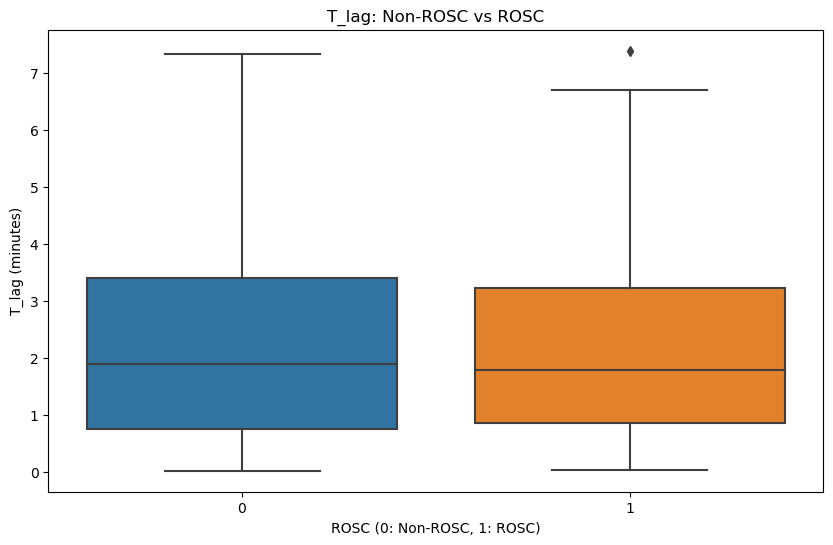

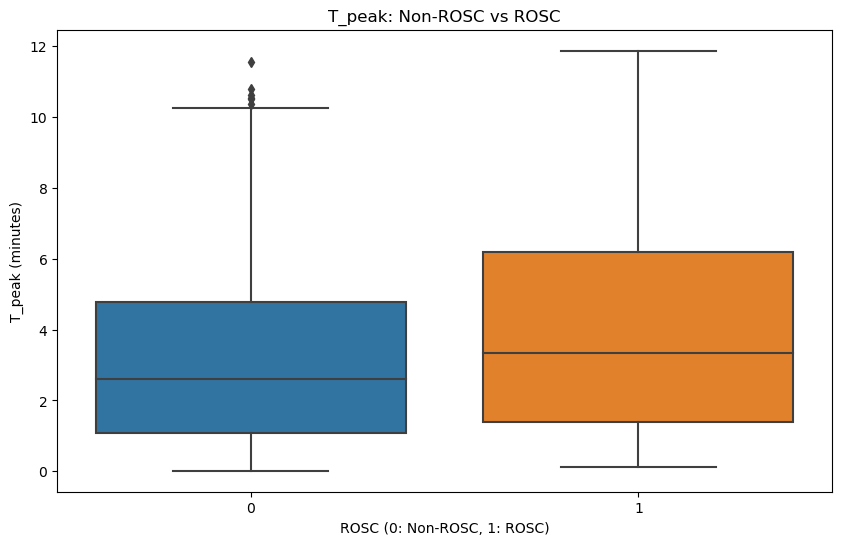

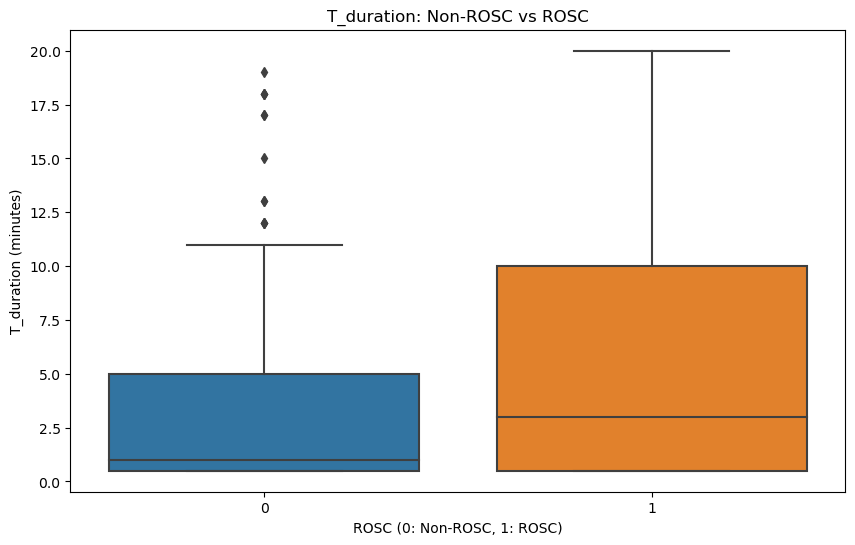

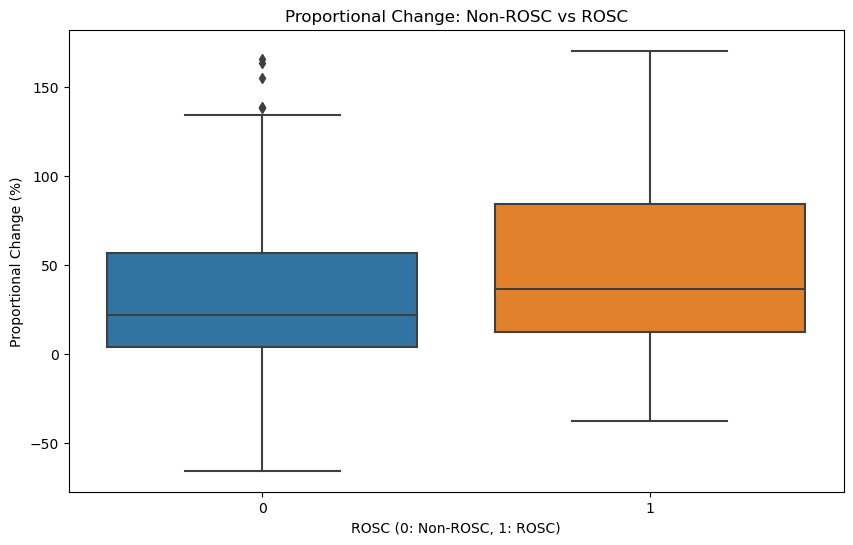

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data from your Excel file
df = pd.read_excel('Single_Epi_Cases_Full.xlsx')
rosc_df = pd.read_excel('filtered_etco2_with_epi_in_range_minus_3min_plus_5min_final_multiple_epitime.xlsx', sheet_name='Sheet2')

# Merge ROSC data with the ETCO₂ data on patientId
df = df.merge(rosc_df[['caseid', 'mnrosc']], left_on='patientId', right_on='caseid', how='left')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

# Create an output folder if it doesn't exist
output_folder = 'ETCO2_Plots_Analysis_Corrected_v3'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Sort by patientId and start time
df = df.sort_values(by=['patientId', 'start'])

# Function to fill missing baseline etco2 using the lowest value within ±3 minutes
def fill_missing_baseline(group):
    for idx, row in group.iterrows():
        if pd.isna(row['etco2']):
            epi_time = row['epi_time']
            
            # Define the time window ±3 minutes around the epinephrine time
            time_window = group[(group['start'] >= epi_time - pd.Timedelta(minutes=3)) & 
                                (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
            
            # If there are valid ETCO₂ values in the time window, find the lowest ETCO₂ and its corresponding time
            if not time_window['etco2'].isna().all():
                baseline_row = time_window.loc[time_window['etco2'].idxmin()]  # Row with lowest ETCO₂
                baseline_etco2 = baseline_row['etco2']
                baseline_time = baseline_row['start']
                
                # Update the row's etco2 value with this baseline and add a new column to store the baseline time
                group.at[idx, 'etco2'] = baseline_etco2
                group.at[idx, 'baseline_time'] = baseline_time  # Store the time of the baseline ETCO₂
            else:
                # If no ETCO₂ value is found within ±3 minutes, leave the etco2 as NaN and baseline_time as NaT
                group.at[idx, 'baseline_time'] = pd.NaT
        else:
            # If the etco2 is already present, set baseline_time to epi_time by default
            group.at[idx, 'baseline_time'] = row['epi_time']
    return group

# Function to analyze ETCO₂ response for each patient with baseline time adjustment
def analyze_etco2_response(group):
    results = []
    epi_rows = group[group['epi_time'].notna()]
    
    for _, epi_row in epi_rows.iterrows():
        epi_time = epi_row['epi_time']
        baseline_etco2 = epi_row['etco2']
        baseline_time = epi_time  # Initialize baseline_time as epi_time initially
        
        # Step 1: If baseline ETCO₂ is missing, recalculate it within ±3 minutes of epi_time
        if pd.isna(baseline_etco2):
            group = fill_missing_baseline(group)
            baseline_etco2 = group.loc[group['epi_time'] == epi_time, 'etco2'].values[0]
        
        # Step 2: Use the new baseline time and value for further calculations
        post_epi_10min = group[(group['start'] > baseline_time) & (group['start'] <= baseline_time + pd.Timedelta(minutes=10))]

        # Calculate T_lag based on new baseline
        t_lag = None
        for idx, row in post_epi_10min.iterrows():
            if row['etco2'] > baseline_etco2 * 1.15:
                t_lag = (row['start'] - baseline_time).total_seconds() / 60
                break

        # Calculate t_duration based on new baseline time
        t_duration = None
        peak_etco2 = None
        time_to_peak = None
        if t_lag is not None and t_lag <= 8.5:
            t_lag_time = baseline_time + pd.Timedelta(minutes=t_lag)
            post_lag = group[group['start'] >= t_lag_time]

             # Calculate T_duration
            consecutive_count = 0
            for idx in range(len(post_lag)):
                if post_lag.iloc[idx]['etco2'] < baseline_etco2 * 1.15:
                    consecutive_count += 1
                else:
                    consecutive_count = 0  # Reset if not consecutive
                if consecutive_count == 2:
                    t_duration = (post_lag.iloc[idx - 1]['start'] - t_lag_time).total_seconds() / 60
                    break
                

            # If still no drop below 115% baseline is found, apply other conditions based on T_lag
            if t_duration is None:
                if t_lag >= 7.5:
                    t_duration = 10 - t_lag
            
            if t_duration is None:
                t_duration = 10
        
            # Calculate peak ETCO₂ and time to peak within t_duration
            etco2_during_duration = post_lag[(post_lag['start'] <= t_lag_time + pd.Timedelta(minutes=t_duration))]

            if not etco2_during_duration.empty:
                peak_etco2 = etco2_during_duration['etco2'].max()
                peak_row = etco2_during_duration[etco2_during_duration['etco2'] == peak_etco2]
                if not peak_row.empty:
                    peak_row = peak_row.iloc[0]
                    time_to_peak = (peak_row['start'] - baseline_time).total_seconds() / 60

        if t_lag is None or (t_lag is not None and (time_to_peak is None or t_duration is None)):
            post_epi_5min = group[(group['start'] > epi_time) & (group['start'] <= epi_time + pd.Timedelta(minutes=5))]
            if not post_epi_5min.empty:
                peak_etco2 = post_epi_5min['etco2'].max()
                peak_row = post_epi_5min[post_epi_5min['etco2'] == peak_etco2]
                if not peak_row.empty:
                    peak_row = peak_row.iloc[0]
                    t_lag = (peak_row['start'] - epi_time).total_seconds() / 60
                    time_to_peak = t_lag
                    t_duration = 0.5  

        # Calculate proportional change and append results
        delta_etco2_peak = peak_etco2 - baseline_etco2 if peak_etco2 else None
        proportional_change = (delta_etco2_peak / baseline_etco2) * 100 if baseline_etco2 and delta_etco2_peak else None

        results.append({
            'patientId': epi_row['patientId'], 
            'epi_time': epi_time, 
            'baseline_etco2': baseline_etco2,
            'baseline_time': baseline_time,
            'peak_etco2': peak_etco2,
            'delta_etco2_peak': delta_etco2_peak,
            'proportional_change': proportional_change,
            't_lag': t_lag,
            'time_to_peak': time_to_peak,
            't_duration': t_duration,
            'rosc': epi_row['mnrosc']  # Add ROSC/Non-ROSC label
        })
        
    return pd.DataFrame(results)

# Now, call analyze_etco2_response function on the grouped data
results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)

# Save the results to Excel
output_filename = 'etco2_tlag_tpeak_tduration_analysis_rosc_non_rosc_with_baseline_time2.xlsx'
results.to_excel(output_filename, index=False)
print(f"Results with accurate baseline time saved to {output_filename}")

# Split the data into ROSC and Non-ROSC groups and calculate averages and medians
rosc_results = results[results['rosc'] == 1]
non_rosc_results = results[results['rosc'] == 0]

# Averages
rosc_avg = rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].mean()
non_rosc_avg = non_rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].mean()

# Medians
rosc_median = rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].median()
non_rosc_median = non_rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].median()

# Display and save summary
print("\nAverages for ROSC group:")
print(rosc_avg)
print("\nAverages for Non-ROSC group:")
print(non_rosc_avg)

print("\nSummary Statistics for ROSC group:")
print(rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].describe())
print(f"Median values for ROSC: \n{rosc_median}")

print("\nSummary Statistics for Non-ROSC group:")
print(non_rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].describe())
print(f"Median values for Non-ROSC: \n{non_rosc_median}")

# Save summary statistics to a new Excel sheet
with pd.ExcelWriter(output_filename, mode='a') as writer:  # Use mode 'a' to append to the existing file
    rosc_results.to_excel(writer, sheet_name='ROSC', index=False)
    non_rosc_results.to_excel(writer, sheet_name='Non_ROSC', index=False)
    rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='ROSC_Averages')
    non_rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='Non_ROSC_Averages')
    rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='ROSC_Medians')
    non_rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='Non_ROSC_Medians')
    rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].describe().to_excel(writer, sheet_name='ROSC_Summary')
    non_rosc_results[['t_lag', 'time_to_peak', 't_duration', 'proportional_change']].describe().to_excel(writer, sheet_name='Non_ROSC_Summary')

print(f"Summary statistics and group-specific results saved to {output_filename}")

# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each metric
results_cleaned_t_lag = remove_outliers(results, 't_lag')
results_cleaned_time_to_peak = remove_outliers(results, 'time_to_peak')
results_cleaned_t_duration = remove_outliers(results, 't_duration')
results_cleaned_proportional_change = remove_outliers(results, 'proportional_change')

# Plotting for ROSC and Non-ROSC groups
# Box plot for T_lag without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='rosc', y='t_lag', data=results_cleaned_t_lag)
plt.title('T_lag: Non-ROSC vs ROSC')
plt.xlabel('ROSC (0: Non-ROSC, 1: ROSC)')
plt.ylabel('T_lag (minutes)')
plt.show()

# Box plot for time_to_peak without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='rosc', y='time_to_peak', data=results_cleaned_time_to_peak)
plt.title('T_peak: Non-ROSC vs ROSC')
plt.xlabel('ROSC (0: Non-ROSC, 1: ROSC)')
plt.ylabel('T_peak (minutes)')
plt.show()

# Box plot for T_duration without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='rosc', y='t_duration', data=results_cleaned_t_duration)
plt.title('T_duration: Non-ROSC vs ROSC')
plt.xlabel('ROSC (0: Non-ROSC, 1: ROSC)')
plt.ylabel('T_duration (minutes)')
plt.show()

# Box plot for proportional_change without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='rosc', y='proportional_change', data=results_cleaned_proportional_change)
plt.title('Proportional Change: Non-ROSC vs ROSC')
plt.xlabel('ROSC (0: Non-ROSC, 1: ROSC)')
plt.ylabel('Proportional Change (%)')
plt.show()


## Significnat Difference single dose

In [27]:
import pandas as pd
from scipy.stats import wilcoxon

# Load the input data file
file_path = 'etco2_tlag_tpeak_tduration_analysis_rosc_non_rosc_with_baseline_time2.xlsx'
df = pd.read_excel(file_path)

# Filter data for ROSC and Non-ROSC groups separately
rosc_data = df[df['rosc'] == 1]
non_rosc_data = df[df['rosc'] == 0]

# Initialize dictionary to store results
metrics = ['t_lag', 'time_to_peak', 't_duration', 'proportional_change']
results = {}

# Run Wilcoxon Signed-Rank Test for each metric
for metric in metrics:
    if metric in rosc_data.columns and metric in non_rosc_data.columns:
        # Drop NaN values for paired test
        rosc_values = rosc_data[metric].dropna()
        non_rosc_values = non_rosc_data[metric].dropna()
        
        # Ensure paired samples have the same length by trimming
        min_len = min(len(rosc_values), len(non_rosc_values))
        rosc_values = rosc_values[:min_len]
        non_rosc_values = non_rosc_values[:min_len]
        
        # Perform the Wilcoxon test
        stat, p_value = wilcoxon(rosc_values, non_rosc_values)
        
        # Save the results
        results[metric] = {
            "Metric": metric,
            "Statistic": stat,
            "p-value": p_value,
            "Significance": "Significant difference" if p_value < 0.05 else "No significant difference"
        }

# Display each metric's result
for metric_result in results.values():
    print(f"{metric_result['Metric']}:")
    print(f"  Statistic: {metric_result['Statistic']}")
    print(f"  p-value: {metric_result['p-value']}")
    print(f"  Significance: {metric_result['Significance']}")
    print("\n")


t_lag:
  Statistic: 4160.5
  p-value: 0.17715549718643453
  Significance: No significant difference


time_to_peak:
  Statistic: 4080.5
  p-value: 0.1286145906599862
  Significance: No significant difference


t_duration:
  Statistic: 1592.5
  p-value: 3.4234599712752485e-05
  Significance: Significant difference


proportional_change:
  Statistic: 2785.0
  p-value: 0.0002693462918777287
  Significance: Significant difference




## Individual plots

In [40]:
import matplotlib.dates as mdates

for _, row in results.iterrows():
    patient_id = row['patientId']
    
    # Filter to include only data from 3 minutes before epi_time to after
    group = df[(df['patientId'] == patient_id) & (df['start'] >= row['epi_time'] - pd.Timedelta(minutes=3))]

    # Set color based on ROSC or Non-ROSC
    if row['rosc'] == 1:
        color = 'green'
    else:
        color = 'blue'

    # Plot the ETCO₂ values with epi_time, T_lag, T_peak, and T_duration
    plt.figure(figsize=(10, 6))
    plt.plot(group['start'], group['etco2'], label='ETCO₂', color=color, marker='o')
    plt.axvline(x=row['epi_time'], color='r', linestyle='--', label='Epinephrine Time', lw=2)

    if pd.notna(row['t_lag']):
        t_lag_time = row['epi_time'] + pd.Timedelta(minutes=row['t_lag'])
        plt.axvline(x=t_lag_time, color='purple', linestyle='-.', label='T_lag', lw=2)

    if pd.notna(row['t_duration']):
        end_time = t_lag_time + pd.Timedelta(minutes=row['t_duration'])
        plt.axvline(x=end_time, color='b', linestyle='-.', label='T_duration', lw=2)

    if pd.notna(row['time_to_peak']):
        t_peak_time = row['epi_time'] + pd.Timedelta(minutes=row['time_to_peak'])
        plt.axvline(x=t_peak_time, color='green', linestyle='--', label='T_peak', lw=2)

    # Customize the plot
    plt.title(f'Patient {patient_id} - ETCO₂ Trend ({"ROSC" if row["rosc"] == 1 else "Non-ROSC"})')
    plt.xlabel('Time')
    plt.ylabel('ETCO₂ Value')

    # Set the x-axis to show 3-minute intervals
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=3))  # 3-minute intervals
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Time format as HH:MM

    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Save plot to file in respective folder
    subfolder = 'ROSC' if row['rosc'] == 1 else 'Non_ROSC'
    patient_plot_folder = os.path.join(output_folder, subfolder)
    if not os.path.exists(patient_plot_folder):
        os.makedirs(patient_plot_folder)

    plot_filename = os.path.join(patient_plot_folder, f'Patient_{patient_id}_ETCO2_Trend.png')
    plt.savefig(plot_filename)
    plt.close()

print(f"Patient ETCO₂ trend plots saved in {output_folder}")


Patient ETCO₂ trend plots saved in ETCO2_Plots_Analysis_Corrected_v3


debug

In [41]:
import pandas as pd
import os

# Load data from your Excel file
df = pd.read_excel('Single_Epi_Cases_Full.xlsx')  # Replace with your actual file

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

output_folder = 'ETCO2_Plots_Analysis_Corrected_v3'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Sort by patientId and start time
df = df.sort_values(by=['patientId', 'start'])

# Function to fill missing baseline etco2 using the lowest value within ±3 minutes
def fill_missing_baseline(group):
    for idx, row in group.iterrows():
        if pd.isna(row['etco2']):
            epi_time = row['epi_time']
            time_window = group[(group['start'] >= epi_time - pd.Timedelta(minutes=3)) 
                               & (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
            if not time_window['etco2'].isna().all():
                row['etco2'] = time_window['etco2'].min()  # Use the lowest ETCO₂ value
            group.at[idx, 'etco2'] = row['etco2']
    return group

# Function to analyze ETCO₂ response for each patient
def analyze_etco2_response(group):
    results = []
    
    # Debugging for a specific patient
    patient_id = group['patientId'].iloc[0]
    debug = (patient_id == 26400)

    epi_rows = group[group['epi_time'].notna()]
    for _, epi_row in epi_rows.iterrows():
        epi_time = epi_row['epi_time']

        # Get baseline ETCO₂ value
        baseline_etco2 = epi_row['etco2']
        
        # Debugging baseline ETCO₂
        if debug:
            print(f'\n[Debug] Patient {patient_id}:')
            print(f' - Epinephrine Time: {epi_time}')
            print(f' - Initial Baseline ETCO₂: {baseline_etco2}')

        # If baseline_etco2 is missing, call fill_missing_baseline function
        if pd.isna(baseline_etco2):
            group = fill_missing_baseline(group)
            baseline_etco2 = group.loc[group['epi_time'] == epi_time, 'etco2'].values[0]  # Re-fetch the filled baseline
        
        # Debugging filled baseline ETCO₂
        if debug:
            print(f' - Filled Baseline ETCO₂: {baseline_etco2}')

        # Get ETCO₂ values within 10 minutes after epinephrine for T_lag and T_peak calculation
        post_epi_10min = group[(group['start'] > epi_time) & (group['start'] <= epi_time + pd.Timedelta(minutes=10))]

        # Debugging post-epinephrine times and ETCO₂ values
        if debug:
            print(f' - Post-Epinephrine ETCO₂ values (within 10 mins):')
            print(post_epi_10min[['start', 'etco2']])

        # Calculate T_lag (first increase where ETCO₂ > 115% of baseline)
        t_lag = None
        for idx, row in post_epi_10min.iterrows():
            if row['etco2'] > baseline_etco2 * 1.15:
                t_lag = (row['start'] - epi_time).total_seconds() / 60  # Time in minutes
                break
        
        if debug:
            print(f' - Calculated T_lag: {t_lag} minutes')

        # If T_lag is None, recalculate baseline ETCO₂ and check again
        if t_lag is None:
            post_3min = group[(group['start'] > epi_time) & (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
            if not post_3min['etco2'].isna().all():
                baseline_etco2 = post_3min['etco2'].min()
                for idx, row in post_epi_10min.iterrows():
                    if row['etco2'] > baseline_etco2 * 1.15:
                        t_lag = (row['start'] - epi_time).total_seconds() / 60
                        break
        
        # Debugging recalculated baseline and T_lag
        if debug:
            print(f' - Recalculated Baseline ETCO₂: {baseline_etco2}')
            print(f' - Recalculated T_lag: {t_lag} minutes')

        # Check for T_duration and peak ETCO₂
        t_duration = None
        peak_etco2 = None
        time_to_peak = None
        
        if t_lag is not None and t_lag <= 8.5:
            t_lag_time = epi_time + pd.Timedelta(minutes=t_lag)
            post_lag = group[group['start'] >= t_lag_time]  # Include the start of T_lag
            
            # Calculate T_duration
            consecutive_count = 0
            for idx in range(len(post_lag)):
                if post_lag.iloc[idx]['etco2'] < baseline_etco2 * 1.15:
                    consecutive_count += 1
                else:
                    consecutive_count = 0  # Reset if not consecutive
                if consecutive_count == 2:
                    t_duration = (post_lag.iloc[idx - 1]['start'] - t_lag_time).total_seconds() / 60
                    break


            # If still no drop below 115% baseline is found, apply other conditions based on T_lag
            if t_duration is None:
                if t_lag >= 7.5:
                    t_duration = 10 - t_lag
                    #print(f"[Debug] No drop below 115% baseline and T_lag >= 7.5, setting T_duration to {t_duration} minutes.")
                else:
                    t_duration = 10
                    #print(f"[Debug] No drop below 115% baseline, setting default T_duration to 10 minutes.")


            # Calculate peak ETCO₂ and T_peak from t_lag
            etco2_during_duration = post_lag[(post_lag['start'] <= t_lag_time + pd.Timedelta(minutes=t_duration))]
            if not etco2_during_duration.empty:
                peak_etco2 = etco2_during_duration['etco2'].max()
                peak_row = etco2_during_duration[etco2_during_duration['etco2'] == peak_etco2]
                if not peak_row.empty:
                    peak_row = peak_row.iloc[0]
                    if peak_row['etco2'] == post_lag.iloc[0]['etco2']:
                        time_to_peak = t_lag
                    else:
                        time_to_peak = (peak_row['start'] - epi_time).total_seconds() / 60
        
        if t_lag is None or (t_lag is not None and (time_to_peak is None or t_duration is None)):
            post_epi_5min = group[(group['start'] > epi_time) & (group['start'] <= epi_time + pd.Timedelta(minutes=5))]
            if not post_epi_5min.empty:
                peak_etco2 = post_epi_5min['etco2'].max()
                peak_row = post_epi_5min[post_epi_5min['etco2'] == peak_etco2]
                if not peak_row.empty:
                    peak_row = peak_row.iloc[0]
                    t_lag = (peak_row['start'] - epi_time).total_seconds() / 60
                    time_to_peak = t_lag
                    t_duration = 0.5

        # Debugging T_duration, peak_etco2, and time_to_peak
        if debug:
            print(f' - T_lag: {t_lag} minutes')
            print(f' - T_duration: {t_duration} minutes')
            print(f' - Peak ETCO₂: {peak_etco2}')
            print(f' - Time to Peak: {time_to_peak} minutes')

        # Calculate proportional change in ETCO₂
        delta_etco2_peak = peak_etco2 - baseline_etco2 if peak_etco2 else None
        proportional_change = (delta_etco2_peak / baseline_etco2) * 100 if baseline_etco2 and delta_etco2_peak else None

        # Debugging final calculations
        if debug:
            print(f' - Delta ETCO₂ Peak: {delta_etco2_peak}')
            print(f' - Proportional Change: {proportional_change}%')

        # Store results
        results.append({
            'patientId': epi_row['patientId'], 
            'epi_time': epi_time, 
            'baseline_etco2': baseline_etco2,
            'peak_etco2': peak_etco2,
            'delta_etco2_peak': delta_etco2_peak,
            'proportional_change': proportional_change,
            't_lag': t_lag,
            'time_to_peak': time_to_peak,
            't_duration': t_duration
        })
        
    return pd.DataFrame(results)

# Group by patientId and analyze the ETCO₂ changes for all patients
results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)

# Save the results to a new Excel file for review
output_filename = 'etco2_tlag_tpeak_tduration_debug_11949.xlsx'
results.to_excel(output_filename, index=False)
print(f"Debug results for patientId 11949 have been saved to {output_filename}")



[Debug] Patient 26400:
 - Epinephrine Time: 1900-01-01 07:45:00
 - Initial Baseline ETCO₂: 11.99804688
 - Filled Baseline ETCO₂: 11.99804688
 - Post-Epinephrine ETCO₂ values (within 10 mins):
                  start      etco2
388 1900-01-01 07:45:57  15.963235
389 1900-01-01 07:46:57        NaN
390 1900-01-01 07:47:57        NaN
391 1900-01-01 07:48:57        NaN
392 1900-01-01 07:49:57        NaN
393 1900-01-01 07:50:57        NaN
394 1900-01-01 07:51:57  21.874219
395 1900-01-01 07:52:57  18.987413
396 1900-01-01 07:53:57  13.357980
397 1900-01-01 07:54:57  14.182617
 - Calculated T_lag: 0.95 minutes
 - Recalculated Baseline ETCO₂: 11.99804688
 - Recalculated T_lag: 0.95 minutes
 - T_lag: 0.95 minutes
 - T_duration: 10 minutes
 - Peak ETCO₂: 21.87421875
 - Time to Peak: 6.95 minutes
 - Delta ETCO₂ Peak: 9.87617187
 - Proportional Change: 82.31482981170015%
Debug results for patientId 11949 have been saved to etco2_tlag_tpeak_tduration_debug_11949.xlsx


## Single epi cases done

## Multi epi case analysis with frst and second epi

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load data from your Excel file
df = pd.read_excel('Multi_Epi_Cases_Full.xlsx')  # This is for multiple epi cases
rosc_df = pd.read_excel('filtered_etco2_with_epi_in_range_minus_3min_plus_5min_final_multiple_epitime.xlsx', sheet_name='Sheet2')

# Merge ROSC data with the ETCO₂ data on patientId
df = df.merge(rosc_df[['caseid', 'mnrosc']], left_on='patientId', right_on='caseid', how='left')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

output_folder = 'ETCO2_Plots_Analysis_Multiple_Epi'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Sort by patientId and start time
df = df.sort_values(by=['patientId', 'start'])

# Function to fill missing baseline etco2 using lowest value within ±3 minutes
def fill_missing_baseline(group):
    for idx, row in group.iterrows():
        if pd.isna(row['etco2']):
            epi_time = row['epi_time']
            time_window = group[(group['start'] >= epi_time - pd.Timedelta(minutes=3)) & 
                                (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
            if not time_window['etco2'].isna().all():
                row['etco2'] = time_window['etco2'].min()  # Use the lowest ETCO₂ value
            group.at[idx, 'etco2'] = row['etco2']
    return group

# Function to analyze ETCO₂ response for each patient
def analyze_etco2_response(group):
    results = []
    epi_rows = group[group['epi_time'].notna()]

    # Handle only the first two epinephrine administrations if multiple epinephrines are present
    if len(epi_rows) > 1:
        first_epi_row = epi_rows.iloc[0]
        second_epi_row = epi_rows.iloc[1]
        first_epi_time = first_epi_row['epi_time']
        second_epi_time = second_epi_row['epi_time']

        # Calculate for the first epinephrine
        baseline_etco2 = first_epi_row['etco2']
        if pd.isna(baseline_etco2):
            group = fill_missing_baseline(group)
            baseline_etco2 = group.loc[group['epi_time'] == first_epi_time, 'etco2'].values[0]

        post_epi_10min = group[(group['start'] > first_epi_time) & (group['start'] <= first_epi_time + pd.Timedelta(minutes=10))]
        
        # Calculate T_lag for the first epinephrine
        t_lag_1 = None
        for idx, row in post_epi_10min.iterrows():
            if row['etco2'] > baseline_etco2 * 1.15:
                t_lag_1 = (row['start'] - first_epi_time).total_seconds() / 60
                break

        # If t_lag_1 is None, recalculate
        if t_lag_1 is None:
            post_3min = group[(group['start'] > first_epi_time) & (group['start'] <= first_epi_time + pd.Timedelta(minutes=3))]
            if not post_3min['etco2'].isna().all():
                baseline_etco2 = post_3min['etco2'].min()
                for idx, row in post_epi_10min.iterrows():
                    if row['etco2'] > baseline_etco2 * 1.15:
                        t_lag_1 = (row['start'] - first_epi_time).total_seconds() / 60
                        break
        
        # Calculate t_duration for the first epinephrine (from first t_lag to second epi_time)
        t_duration_1 = None
        if t_lag_1 is not None:
            t_lag_time_1 = first_epi_time + pd.Timedelta(minutes=t_lag_1)
            t_duration_1 = (second_epi_time - t_lag_time_1).total_seconds() / 60  # Time between first t_lag and second epi_time

        # Calculate t_peak and proportional change for first epinephrine
        t_peak_1 = None
        peak_etco2_1 = None
        if t_lag_1 is not None:
            etco2_during_duration_1 = group[(group['start'] >= t_lag_time_1) & (group['start'] <= second_epi_time)]
            if not etco2_during_duration_1.empty:
                peak_etco2_1 = etco2_during_duration_1['etco2'].max()
                peak_row_1 = etco2_during_duration_1[etco2_during_duration_1['etco2'] == peak_etco2_1].iloc[0]
                t_peak_1 = (peak_row_1['start'] - first_epi_time).total_seconds() / 60

        # Calculate proportional change for the first epinephrine
        proportional_change_1 = (peak_etco2_1 - baseline_etco2) / baseline_etco2 * 100 if peak_etco2_1 else None

        # Calculate T_lag, time_to_peak, t_duration, and proportional change for the second epinephrine
        baseline_etco2_2 = second_epi_row['etco2']
        post_epi_10min_2 = group[(group['start'] > second_epi_time) & (group['start'] <= second_epi_time + pd.Timedelta(minutes=10))]
        
        t_lag_2 = None
        for idx, row in post_epi_10min_2.iterrows():
            if row['etco2'] > baseline_etco2_2 * 1.15:
                t_lag_2 = (row['start'] - second_epi_time).total_seconds() / 60
                break

        t_duration_2 = None
        t_peak_2 = None
        peak_etco2_2 = None
        if t_lag_2 is not None:
            t_lag_time_2 = second_epi_time + pd.Timedelta(minutes=t_lag_2)
            post_lag_2 = group[group['start'] >= t_lag_time_2]

            consecutive_count = 0
            for idx in range(len(post_lag_2)):
                if post_lag_2.iloc[idx]['etco2'] < baseline_etco2_2 * 1.15:
                    consecutive_count += 1
                else:
                    consecutive_count = 0

                if consecutive_count == 2:
                    t_duration_2 = (post_lag_2.iloc[idx - 1]['start'] - t_lag_time_2).total_seconds() / 60
                    break

            if t_duration_2 is None:
                t_duration_2 = 10  # If no drop, set it to 10 mins

            etco2_during_duration_2 = post_lag_2[(post_lag_2['start'] <= t_lag_time_2 + pd.Timedelta(minutes=t_duration_2))]

            if not etco2_during_duration_2.empty:
                peak_etco2_2 = etco2_during_duration_2['etco2'].max()
                peak_row_2 = etco2_during_duration_2[etco2_during_duration_2['etco2'] == peak_etco2_2].iloc[0]
                t_peak_2 = (peak_row_2['start'] - second_epi_time).total_seconds() / 60

        # Calculate proportional change for the second epinephrine
        proportional_change_2 = (peak_etco2_2 - baseline_etco2_2) / baseline_etco2_2 * 100 if peak_etco2_2 else None

        # Store results for first and second epinephrine
        results.append({
            'patientId': first_epi_row['patientId'],
            'epi_time_1': first_epi_time,
            't_lag_1': t_lag_1,
            't_duration_1': t_duration_1,
            't_peak_1': t_peak_1,
            'proportional_change_1': proportional_change_1,
            'epi_time_2': second_epi_time,
            't_lag_2': t_lag_2,
            't_duration_2': t_duration_2,
            't_peak_2': t_peak_2,
            'proportional_change_2': proportional_change_2,
            'peak_etco2_2': peak_etco2_2
        })

    return pd.DataFrame(results)


results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)



# Save the results to Excel
output_filename = 'multiple_epi_analysis.xlsx'
results.to_excel(output_filename, index=False)
print(f"Results have been saved to {output_filename}")



Results have been saved to multiple_epi_analysis.xlsx


## Multi epi case correcetion baseline

In [53]:
import pandas as pd
import os

# Load data from your Excel file
df = pd.read_excel('Multi_Epi_Cases_Full.xlsx')
rosc_df = pd.read_excel('filtered_etco2_with_epi_in_range_minus_3min_plus_5min_final_multiple_epitime.xlsx', sheet_name='Sheet2')

# Merge ROSC data with the ETCO₂ data on patientId
df = df.merge(rosc_df[['caseid', 'mnrosc']], left_on='patientId', right_on='caseid', how='left')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

output_folder = 'ETCO2_Plots_Analysis_Multiple_Epi'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Sort by patientId and start time
df = df.sort_values(by=['patientId', 'start'])

# Function to fill missing baseline etco2 using the lowest value within ±3 minutes
def fill_missing_baseline(group):
    for idx, row in group.iterrows():
        if pd.isna(row['etco2']):
            epi_time = row['epi_time']
            time_window = group[(group['start'] >= epi_time - pd.Timedelta(minutes=3)) & 
                                (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
            if not time_window['etco2'].isna().all():
                baseline_row = time_window.loc[time_window['etco2'].idxmin()]
                group.at[idx, 'etco2'] = baseline_row['etco2']
                group.at[idx, 'baseline_time'] = baseline_row['start']
            else:
                group.at[idx, 'baseline_time'] = pd.NaT
        else:
            group.at[idx, 'baseline_time'] = row['epi_time']
    return group

# Function to analyze ETCO₂ response for each patient with multiple epinephrine events
def analyze_etco2_response(group):
    results = []
    epi_rows = group[group['epi_time'].notna()]
    proportional_change_1= None
    proportional_change_2= None

    # Check for ROSC status from 'mnrosc' and add it to each entry
    rosc_status = group['mnrosc'].iloc[0] if 'mnrosc' in group.columns else None

    if len(epi_rows) >= 2:  # We need at least two epinephrine events for this analysis
        # Handling the first epinephrine
        first_epi_row = epi_rows.iloc[0]
        second_epi_row = epi_rows.iloc[1]
        first_epi_time = first_epi_row['epi_time']
        second_epi_time = second_epi_row['epi_time']

        # Perform the analysis for the first epinephrine
        baseline_etco2 = first_epi_row['etco2']
        baseline_time = first_epi_time
        if pd.isna(baseline_etco2):
            group = fill_missing_baseline(group)
            baseline_etco2 = group.loc[group['epi_time'] == first_epi_time, 'etco2'].values[0]

        post_epi_10min = group[(group['start'] > baseline_time) & (group['start'] <= second_epi_time)]

        # Calculate T_lag for first epinephrine
        t_lag_1 = None
        for idx, row in post_epi_10min.iterrows():
            if row['etco2'] > baseline_etco2 * 1.15:
                t_lag_1 = (row['start'] - baseline_time).total_seconds() / 60
                break

        # Calculate T_duration for first epinephrine (ends at the second epi time)
        t_duration_1 = None
        peak_etco2_1 = None
        time_to_peak_1 = None
        if t_lag_1 is not None and t_lag_1 <= 8.5:
            t_lag_time_1 = baseline_time + pd.Timedelta(minutes=t_lag_1)
            post_lag_1 = group[(group['start'] >= t_lag_time_1) & (group['start'] < second_epi_time)]

            # Calculate T_duration
            consecutive_count = 0
            for idx in range(len(post_lag_1)):
                if post_lag_1.iloc[idx]['etco2'] < baseline_etco2 * 1.15:
                    consecutive_count += 1
                else:
                    consecutive_count = 0
                if consecutive_count == 2:
                    t_duration_1 = (post_lag_1.iloc[idx - 1]['start'] - t_lag_time_1).total_seconds() / 60
                    break

            if t_duration_1 is None:
                t_duration_1 = (second_epi_time - t_lag_time_1).total_seconds() / 60

            etco2_during_duration_1 = post_lag_1[(post_lag_1['start'] <= t_lag_time_1 + pd.Timedelta(minutes=t_duration_1))]
            if not etco2_during_duration_1.empty:
                peak_etco2_1 = etco2_during_duration_1['etco2'].max()
                peak_row_1 = etco2_during_duration_1[etco2_during_duration_1['etco2'] == peak_etco2_1]
                if not peak_row_1.empty:
                    time_to_peak_1 = (peak_row_1['start'].iloc[0] - baseline_time).total_seconds() / 60


        # Calculate proportional change for first epinephrine
        if peak_etco2_1 and baseline_etco2:
            proportional_change_1 = ((peak_etco2_1 - baseline_etco2) / baseline_etco2) * 100

        # Repeat the process for the second epinephrine
        baseline_etco2_2 = second_epi_row['etco2']
        baseline_time_2 = second_epi_time
        post_epi_10min_2 = group[(group['start'] > baseline_time_2) & (group['start'] <= baseline_time_2 + pd.Timedelta(minutes=10))]

        t_lag_2, t_duration_2, peak_etco2_2, time_to_peak_2 = None, None, None, None
        for idx, row in post_epi_10min_2.iterrows():
            if row['etco2'] > baseline_etco2_2 * 1.15:
                t_lag_2 = (row['start'] - baseline_time_2).total_seconds() / 60
                break

        if t_lag_2 is not None and t_lag_2 <= 8.5:
            t_lag_time_2 = baseline_time_2 + pd.Timedelta(minutes=t_lag_2)
            post_lag_2 = group[group['start'] >= t_lag_time_2]

            consecutive_count_2 = 0
            for idx in range(len(post_lag_2)):
                if post_lag_2.iloc[idx]['etco2'] < baseline_etco2_2 * 1.15:
                    consecutive_count_2 += 1
                else:
                    consecutive_count_2 = 0
                if consecutive_count_2 == 2:
                    t_duration_2 = (post_lag_2.iloc[idx - 1]['start'] - t_lag_time_2).total_seconds() / 60
                    break
            if t_duration_2 is None:
                t_duration_2 = 12

            etco2_during_duration_2 = post_lag_2[(post_lag_2['start'] <= t_lag_time_2 + pd.Timedelta(minutes=t_duration_2))]
            if not etco2_during_duration_2.empty:
                peak_etco2_2 = etco2_during_duration_2['etco2'].max()
                peak_row_2 = etco2_during_duration_2[etco2_during_duration_2['etco2'] == peak_etco2_2]
                if not peak_row_2.empty:
                    time_to_peak_2 = (peak_row_2['start'].iloc[0] - baseline_time_2).total_seconds() / 60

        # Calculate proportional change for second epinephrine
        if peak_etco2_2 and baseline_etco2_2:
            proportional_change_2 = ((peak_etco2_2 - baseline_etco2_2) / baseline_etco2_2) * 100

        # Append the results for both epinephrines, including the ROSC status
        results.append({
            'patientId': first_epi_row['patientId'],
            'rosc': rosc_status,
            'epi_time_1': first_epi_time,
            't_lag_1': t_lag_1,
            't_duration_1': t_duration_1,
            'time_to_peak_1': time_to_peak_1,
            'peak_etco2_1': peak_etco2_1,
            'proportional_change_1': proportional_change_1,
            'epi_time_2': second_epi_time,
            't_lag_2': t_lag_2,
            't_duration_2': t_duration_2,
            'time_to_peak_2': time_to_peak_2,
            'peak_etco2_2': peak_etco2_2,
            'proportional_change_2': proportional_change_2,
        })

    return pd.DataFrame(results)


# Run analysis on grouped data
results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)

# Save the results to Excel
output_filename = 'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi.xlsx'
results.to_excel(output_filename, index=False)
print(f"Results for multiple epinephrine analysis saved to {output_filename}")

# Check and rename 'mnrosc' to 'rosc' if necessary in the results DataFrame
if 'mnrosc' in results.columns:
    results.rename(columns={'mnrosc': 'rosc'}, inplace=True)

# Now split the data into ROSC and Non-ROSC groups
rosc_results = results[results['rosc'] == 1]
non_rosc_results = results[results['rosc'] == 0]


# Split the data into ROSC and Non-ROSC groups and calculate averages and medians
rosc_results = results[results['rosc'] == 1]
non_rosc_results = results[results['rosc'] == 0]

# Averages
rosc_avg = rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                         't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].mean()
non_rosc_avg = non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                                 't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].mean()

# Medians
rosc_median = rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                            't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].median()
non_rosc_median = non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                                    't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].median()

# Display and save summary
print("\nAverages for ROSC group (Multiple Epinephrine):")
print(rosc_avg)
print("\nAverages for Non-ROSC group (Multiple Epinephrine):")
print(non_rosc_avg)

print("\nSummary Statistics for ROSC group (Multiple Epinephrine):")
print(rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                    't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe())
print(f"Median values for ROSC: \n{rosc_median}")

print("\nSummary Statistics for Non-ROSC group (Multiple Epinephrine):")
print(non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                        't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe())
print(f"Median values for Non-ROSC: \n{non_rosc_median}")

# Save summary statistics to a new Excel sheet
with pd.ExcelWriter(output_filename, mode='a') as writer:
    rosc_results.to_excel(writer, sheet_name='ROSC', index=False)
    non_rosc_results.to_excel(writer, sheet_name='Non_ROSC', index=False)
    rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='ROSC_Averages')
    non_rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='Non_ROSC_Averages')
    rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='ROSC_Medians')
    non_rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='Non_ROSC_Medians')
    rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                  't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe().to_excel(writer, sheet_name='ROSC_Summary')
    non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                      't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe().to_excel(writer, sheet_name='Non_ROSC_Summary')

print(f"Summary statistics and group-specific results saved to {output_filename}")



Results for multiple epinephrine analysis saved to etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi.xlsx

Averages for ROSC group (Multiple Epinephrine):
t_lag_1                   1.572549
t_duration_1              4.423529
time_to_peak_1            3.469792
peak_etco2_1             50.493177
proportional_change_1    82.857567
t_lag_2                   2.633333
t_duration_2              5.789474
time_to_peak_2            4.107018
peak_etco2_2             61.584155
proportional_change_2    44.769430
dtype: float64

Averages for Non-ROSC group (Multiple Epinephrine):
t_lag_1                   2.136828
t_duration_1              3.325956
time_to_peak_1            3.485519
peak_etco2_1             41.932235
proportional_change_1    56.670093
t_lag_2                   2.411905
t_duration_2              7.589286
time_to_peak_2            4.197619
peak_etco2_2             42.360477
proportional_change_2    54.673314
dtype: float64

Summary Statistics for ROSC group (Multipl

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data files
df_cases = pd.read_excel('Multi_Epi_Cases_Full.xlsx')
df_analysis = pd.read_excel('etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi.xlsx')

# Merge the data on 'patientId'
df = df_cases.merge(df_analysis[['patientId', 'rosc', 'epi_time_1', 't_lag_1', 't_duration_1', 'time_to_peak_1',
                                 'peak_etco2_1', 'proportional_change_1', 'epi_time_2', 't_lag_2', 
                                 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']],
                    on='patientId', how='left')

# Convert time columns to datetime
df['start'] = pd.to_datetime(df['start'], errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], errors='coerce')

# Create the directory for saving plots if it doesn’t exist
output_folder = 'ETCO2_Plots_Multiple_Epi_Patients'
os.makedirs(output_folder, exist_ok=True)


# Iterate over each patient in the results
for _, row in results.iterrows():
    patient_id = row['patientId']
    
    # Filter ETCO₂ data for this patient, showing 3 minutes before the first epinephrine event onward
    group = df[(df['patientId'] == patient_id) & (df['start'] >= row['epi_time_1'] - pd.Timedelta(minutes=3))]
    
    # Determine color based on ROSC or Non-ROSC
    color = 'green' if row['rosc'] == 1 else 'blue'
    
    # Plot the ETCO₂ trend for the patient
    plt.figure(figsize=(12, 6))
    plt.plot(group['start'], group['etco2'], label='ETCO₂', color=color, marker='o')
    
    # Plot markers for the first epinephrine event
    plt.axvline(x=row['epi_time_1'], color='red', linestyle='--', label='Epinephrine 1', lw=2)
    
    if pd.notna(row['t_lag_1']):
        t_lag_1_time = row['epi_time_1'] + pd.Timedelta(minutes=row['t_lag_1'])
        plt.axvline(x=t_lag_1_time, color='purple', linestyle='-.', label='T_lag 1', lw=2)

    if pd.notna(row['t_duration_1']):
        t_duration_1_end = t_lag_1_time + pd.Timedelta(minutes=row['t_duration_1'])
        plt.axvline(x=t_duration_1_end, color='blue', linestyle='-.', label='T_duration 1', lw=2)

    if pd.notna(row['time_to_peak_1']):
        t_peak_1_time = row['epi_time_1'] + pd.Timedelta(minutes=row['time_to_peak_1'])
        plt.axvline(x=t_peak_1_time, color='green', linestyle='--', label='T_peak 1', lw=2)

    # Plot markers for the second epinephrine event, if available
    if pd.notna(row['epi_time_2']):
        plt.axvline(x=row['epi_time_2'], color='red', linestyle='--', label='Epinephrine 2', lw=2, alpha=0.6)

        if pd.notna(row['t_lag_2']):
            t_lag_2_time = row['epi_time_2'] + pd.Timedelta(minutes=row['t_lag_2'])
            plt.axvline(x=t_lag_2_time, color='purple', linestyle='-.', label='T_lag 2', lw=2, alpha=0.6)

        if pd.notna(row['t_duration_2']):
            t_duration_2_end = t_lag_2_time + pd.Timedelta(minutes=row['t_duration_2'])
            plt.axvline(x=t_duration_2_end, color='blue', linestyle='-.', label='T_duration 2', lw=2, alpha=0.6)

        if pd.notna(row['time_to_peak_2']):
            t_peak_2_time = row['epi_time_2'] + pd.Timedelta(minutes=row['time_to_peak_2'])
            plt.axvline(x=t_peak_2_time, color='green', linestyle='--', label='T_peak 2', lw=2, alpha=0.6)

    # Set plot details
    plt.title(f'Patient {patient_id} - ETCO₂ Trend ({"ROSC" if row["rosc"] == 1 else "Non-ROSC"})')
    plt.xlabel('Time')
    plt.ylabel('ETCO₂ Value')
    
    # Format the x-axis to show time in HH:MM
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Save the plot in the appropriate folder
    subfolder = 'ROSC' if row['rosc'] == 1 else 'Non_ROSC'
    patient_plot_folder = os.path.join(output_folder, subfolder)
    if not os.path.exists(patient_plot_folder):
        os.makedirs(patient_plot_folder)

    plot_filename = os.path.join(patient_plot_folder, f'Patient_{patient_id}_ETCO2_Trend.png')
    plt.savefig(plot_filename)
    plt.close()

print(f"Patient ETCO₂ trend plots saved in {output_folder}")

Patient ETCO₂ trend plots saved in ETCO2_Plots_Multiple_Epi_Patients


## the above is right. Justr have to include plots for proportional chnage. and min map for patient group

## Below updating improved logic for multiple epi

In [4]:
import pandas as pd
import os

# Load data from your Excel file
df = pd.read_excel('Multi_Epi_Cases_Full.xlsx')
rosc_df = pd.read_excel('filtered_etco2_with_epi_in_range_minus_3min_plus_5min_final_multiple_epitime.xlsx', sheet_name='Sheet2')

# Merge ROSC data with the ETCO₂ data on patientId
df = df.merge(rosc_df[['caseid', 'mnrosc']], left_on='patientId', right_on='caseid', how='left')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

output_folder = 'ETCO2_Plots_Analysis_Multiple_Epi222'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Sort by patientId and start time
df = df.sort_values(by=['patientId', 'start'])

# Function to fill missing baseline etco2 using the lowest value within ±3 minutes
def fill_missing_baseline(group, epi_time):
    time_window = group[(group['start'] >= epi_time - pd.Timedelta(minutes=3)) &
                        (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
    if not time_window['etco2'].isna().all():
        return time_window['etco2'].min()
    return None

# Function to analyze ETCO₂ response for each patient with two epinephrine events
def analyze_etco2_response(group):
    results = []
    epi_rows = group[group['epi_time'].notna()]

    # Check for ROSC status from 'mnrosc' and add it to each entry
    rosc_status = group['mnrosc'].iloc[0] if 'mnrosc' in group.columns else None

    if len(epi_rows) >= 2:  # Ensure at least two epinephrine events for this analysis
        # Handling the first epinephrine
        first_epi_time = epi_rows.iloc[0]['epi_time']
        second_epi_time = epi_rows.iloc[1]['epi_time']

        # Calculate baseline ETCO₂ for the first epinephrine
        baseline_etco2_1 = epi_rows.iloc[0]['etco2']
        if pd.isna(baseline_etco2_1):
            baseline_etco2_1 = fill_missing_baseline(group, first_epi_time)

        post_epi_10min = group[(group['start'] > first_epi_time) & (group['start'] <= second_epi_time)]

        # Calculate T_lag for first epinephrine
        t_lag_1 = None
        for idx, row in post_epi_10min.iterrows():
            if row['etco2'] > baseline_etco2_1 * 1.15:
                t_lag_1 = (row['start'] - first_epi_time).total_seconds() / 60
                break

        # Recalculate baseline if T_lag_1 is None
        if t_lag_1 is None:
            recalculated_baseline_1 = fill_missing_baseline(group, first_epi_time + pd.Timedelta(minutes=3))
            if recalculated_baseline_1 is not None:
                baseline_etco2_1 = recalculated_baseline_1
                for idx, row in post_epi_10min.iterrows():
                    if row['etco2'] > baseline_etco2_1 * 1.15:
                        t_lag_1 = (row['start'] - first_epi_time).total_seconds() / 60
                        break

        # Calculate T_duration for the first epinephrine, ending at the second epinephrine time
        t_duration_1 = None
        peak_etco2_1 = None
        time_to_peak_1 = None
        if t_lag_1 is not None and t_lag_1 <= 8.5:
            t_lag_time_1 = first_epi_time + pd.Timedelta(minutes=t_lag_1)
            post_lag_1 = group[(group['start'] >= t_lag_time_1) & (group['start'] < second_epi_time)]

            # Calculate T_duration until the second epinephrine
            consecutive_count = 0
            for idx in range(len(post_lag_1)):
                if post_lag_1.iloc[idx]['etco2'] < baseline_etco2_1 * 1.15:
                    consecutive_count += 1
                else:
                    consecutive_count = 0
                if consecutive_count == 2:
                    t_duration_1 = (post_lag_1.iloc[idx - 1]['start'] - t_lag_time_1).total_seconds() / 60
                    break

            if t_duration_1 is None:
                t_duration_1 = (second_epi_time - t_lag_time_1).total_seconds() / 60

            etco2_during_duration_1 = post_lag_1[(post_lag_1['start'] <= t_lag_time_1 + pd.Timedelta(minutes=t_duration_1))]
            if not etco2_during_duration_1.empty:
                peak_etco2_1 = etco2_during_duration_1['etco2'].max()
                peak_row_1 = etco2_during_duration_1[etco2_during_duration_1['etco2'] == peak_etco2_1]
                if not peak_row_1.empty:
                    time_to_peak_1 = (peak_row_1['start'].iloc[0] - first_epi_time).total_seconds() / 60

        # Proportional change for the first epinephrine
        proportional_change_1 = ((peak_etco2_1 - baseline_etco2_1) / baseline_etco2_1) * 100 if peak_etco2_1 and baseline_etco2_1 else None

        # Repeat the process for the second epinephrine
        baseline_etco2_2 = epi_rows.iloc[1]['etco2']
        if pd.isna(baseline_etco2_2):
            baseline_etco2_2 = fill_missing_baseline(group, second_epi_time)

        post_epi_10min_2 = group[(group['start'] > second_epi_time) & (group['start'] <= second_epi_time + pd.Timedelta(minutes=10))]

        # Calculate T_lag for the second epinephrine
        t_lag_2 = None
        for idx, row in post_epi_10min_2.iterrows():
            if row['etco2'] > baseline_etco2_2 * 1.15:
                t_lag_2 = (row['start'] - second_epi_time).total_seconds() / 60
                break

        # Recalculate baseline if T_lag_2 is None
        if t_lag_2 is None:
            recalculated_baseline_2 = fill_missing_baseline(group, second_epi_time + pd.Timedelta(minutes=3))
            if recalculated_baseline_2 is not None:
                baseline_etco2_2 = recalculated_baseline_2
                for idx, row in post_epi_10min_2.iterrows():
                    if row['etco2'] > baseline_etco2_2 * 1.15:
                        t_lag_2 = (row['start'] - second_epi_time).total_seconds() / 60
                        break

        # Calculate T_duration, peak ETCO₂, and proportional change for the second epinephrine
        t_duration_2 = None
        peak_etco2_2 = None
        time_to_peak_2 = None
        if t_lag_2 is not None and t_lag_2 <= 8.5:
            t_lag_time_2 = second_epi_time + pd.Timedelta(minutes=t_lag_2)
            post_lag_2 = group[(group['start'] >= t_lag_time_2)]

            consecutive_count_2 = 0
            for idx in range(len(post_lag_2)):
                if post_lag_2.iloc[idx]['etco2'] < baseline_etco2_2 * 1.15:
                    consecutive_count_2 += 1
                else:
                    consecutive_count_2 = 0
                if consecutive_count_2 == 2:
                    t_duration_2 = (post_lag_2.iloc[idx - 1]['start'] - t_lag_time_2).total_seconds() / 60
                    break

                if consecutive_count_2 == 1:
                    t_duration_2 = (post_lag_2.iloc[idx]['start'] - t_lag_time_2).total_seconds() / 60
                    break

            if t_duration_2 is None:
                t_duration_2 = 4  # Default if no drop below threshold is observed within 10 mins

            etco2_during_duration_2 = post_lag_2[(post_lag_2['start'] <= t_lag_time_2 + pd.Timedelta(minutes=t_duration_2))]
            if not etco2_during_duration_2.empty:
                peak_etco2_2 = etco2_during_duration_2['etco2'].max()
                peak_row_2 = etco2_during_duration_2[etco2_during_duration_2['etco2'] == peak_etco2_2]
                if not peak_row_2.empty:
                    time_to_peak_2 = (peak_row_2['start'].iloc[0] - second_epi_time).total_seconds() / 60

        # Proportional change for the second epinephrine
        proportional_change_2 = ((peak_etco2_2 - baseline_etco2_2) / baseline_etco2_2) * 100 if peak_etco2_2 and baseline_etco2_2 else None

        results.append({
            'patientId': epi_rows.iloc[0]['patientId'],
            'rosc': rosc_status,
            'epi_time_1': first_epi_time,
            't_lag_1': t_lag_1,
            't_duration_1': t_duration_1,
            'time_to_peak_1': time_to_peak_1,
            'peak_etco2_1': peak_etco2_1,
            'proportional_change_1': proportional_change_1,
            'epi_time_2': second_epi_time,
            't_lag_2': t_lag_2,
            't_duration_2': t_duration_2,
            'time_to_peak_2': time_to_peak_2,
            'peak_etco2_2': peak_etco2_2,
            'proportional_change_2': proportional_change_2,
        })

    return pd.DataFrame(results)

# Run analysis on grouped data
results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)

# Save the results to Excel
output_filename = 'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi_filtered.xlsx'
results.to_excel(output_filename, index=False)
print(f"Results for multiple epinephrine analysis saved to {output_filename}")

# Check and rename 'mnrosc' to 'rosc' if necessary in the results DataFrame
if 'mnrosc' in results.columns:
    results.rename(columns={'mnrosc': 'rosc'}, inplace=True)

# Filter data to include only rows with valid values for both doses
filtered_results = results.dropna(subset=['t_lag_1', 'time_to_peak_1', 't_lag_2', 'time_to_peak_2'])

# Split data into ROSC and Non-ROSC groups for summary statistics
rosc_results = filtered_results[filtered_results['rosc'] == 1]
non_rosc_results = filtered_results[filtered_results['rosc'] == 0]

# Calculate averages and medians for each group
rosc_avg = rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                         't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].mean()
non_rosc_avg = non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                                 't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].mean()

rosc_median = rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                            't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].median()
non_rosc_median = non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                                    't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].median()

# Display and save summary
print("\nAverages for ROSC group (Multiple Epinephrine):")
print(rosc_avg)
print("\nAverages for Non-ROSC group (Multiple Epinephrine):")
print(non_rosc_avg)

print("\nSummary Statistics for ROSC group (Multiple Epinephrine):")
print(rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                    't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe())
print(f"Median values for ROSC: \n{rosc_median}")

print("\nSummary Statistics for Non-ROSC group (Multiple Epinephrine):")
print(non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                        't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe())
print(f"Median values for Non-ROSC: \n{non_rosc_median}")

# Save summary statistics to a new Excel sheet
with pd.ExcelWriter(output_filename, mode='a') as writer:
    rosc_results.to_excel(writer, sheet_name='ROSC', index=False)
    non_rosc_results.to_excel(writer, sheet_name='Non_ROSC', index=False)
    rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='ROSC_Averages')
    non_rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='Non_ROSC_Averages')
    rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='ROSC_Medians')
    non_rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='Non_ROSC_Medians')
    rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                  't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe().to_excel(writer, sheet_name='ROSC_Summary')
    non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                      't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe().to_excel(writer, sheet_name='Non_ROSC_Summary')

print(f"Summary statistics and group-specific results saved to {output_filename}")


'''

# Run analysis on grouped data
results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)

# Save the results to Excel
output_filename = 'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi2222.xlsx'
results.to_excel(output_filename, index=False)
print(f"Results for multiple epinephrine analysis saved to {output_filename}")

# Check and rename 'mnrosc' to 'rosc' if necessary in the results DataFrame
if 'mnrosc' in results.columns:
    results.rename(columns={'mnrosc': 'rosc'}, inplace=True)

# Split data into ROSC and Non-ROSC groups for summary statistics
rosc_results = results[results['rosc'] == 1]
non_rosc_results = results[results['rosc'] == 0]

# Calculate averages and medians for each group
rosc_avg = rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                         't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].mean()
non_rosc_avg = non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                                 't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].mean()

rosc_median = rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                            't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].median()
non_rosc_median = non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                                    't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].median()


# Display and save summary
print("\nAverages for ROSC group (Multiple Epinephrine):")
print(rosc_avg)
print("\nAverages for Non-ROSC group (Multiple Epinephrine):")
print(non_rosc_avg)

print("\nSummary Statistics for ROSC group (Multiple Epinephrine):")
print(rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                    't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe())
print(f"Median values for ROSC: \n{rosc_median}")

print("\nSummary Statistics for Non-ROSC group (Multiple Epinephrine):")
print(non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                        't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe())
print(f"Median values for Non-ROSC: \n{non_rosc_median}")


# Save summary statistics to a new Excel sheet
with pd.ExcelWriter(output_filename, mode='a') as writer:
    rosc_results.to_excel(writer, sheet_name='ROSC', index=False)
    non_rosc_results.to_excel(writer, sheet_name='Non_ROSC', index=False)
    rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='ROSC_Averages')
    non_rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='Non_ROSC_Averages')
    rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='ROSC_Medians')
    non_rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='Non_ROSC_Medians')
    rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                  't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe().to_excel(writer, sheet_name='ROSC_Summary')
    non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                      't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe().to_excel(writer, sheet_name='Non_ROSC_Summary')

print(f"Summary statistics and group-specific results saved to {output_filename}")
'''


Results for multiple epinephrine analysis saved to etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi_filtered.xlsx

Averages for ROSC group (Multiple Epinephrine):
t_lag_1                   1.311111
t_duration_1              4.341667
time_to_peak_1            3.144444
peak_etco2_1             48.694354
proportional_change_1    76.251166
t_lag_2                   2.358333
t_duration_2              3.333333
time_to_peak_2            3.191667
peak_etco2_2             59.622680
proportional_change_2    39.150848
dtype: float64

Averages for Non-ROSC group (Multiple Epinephrine):
t_lag_1                   1.601718
t_duration_1              2.992096
time_to_peak_1            2.653265
peak_etco2_1             36.294182
proportional_change_1    60.967420
t_lag_2                   1.774742
t_duration_2              3.175258
time_to_peak_2            2.640722
peak_etco2_2             37.258682
proportional_change_2    48.735147
dtype: float64

Summary Statistics for ROSC group

'\n\n# Run analysis on grouped data\nresults = df.groupby(\'patientId\', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)\n\n# Save the results to Excel\noutput_filename = \'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi2222.xlsx\'\nresults.to_excel(output_filename, index=False)\nprint(f"Results for multiple epinephrine analysis saved to {output_filename}")\n\n# Check and rename \'mnrosc\' to \'rosc\' if necessary in the results DataFrame\nif \'mnrosc\' in results.columns:\n    results.rename(columns={\'mnrosc\': \'rosc\'}, inplace=True)\n\n# Split data into ROSC and Non-ROSC groups for summary statistics\nrosc_results = results[results[\'rosc\'] == 1]\nnon_rosc_results = results[results[\'rosc\'] == 0]\n\n# Calculate averages and medians for each group\nrosc_avg = rosc_results[[\'t_lag_1\', \'t_duration_1\', \'time_to_peak_1\', \'peak_etco2_1\', \'proportional_change_1\', \n                         \'t_lag_2\', \'t_duration_2\', \'time_to_peak

## T_Duration 3rd epi analyis

In [2]:
import pandas as pd
import os

# Load data from your Excel file
df = pd.read_excel('Multi_Epi_Cases_Full.xlsx')
rosc_df = pd.read_excel('filtered_etco2_with_epi_in_range_minus_3min_plus_5min_final_multiple_epitime.xlsx', sheet_name='Sheet2')

# Merge ROSC data with the ETCO₂ data on patientId
df = df.merge(rosc_df[['caseid', 'mnrosc']], left_on='patientId', right_on='caseid', how='left')

# Convert time columns to datetime for easier comparison
df['start'] = pd.to_datetime(df['start'], format='%H:%M:%S', errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], format='%H:%M:%S', errors='coerce')

output_folder = 'ETCO2_Plots_Analysis_Multiple_Epi333'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Sort by patientId and start time
df = df.sort_values(by=['patientId', 'start'])

# Function to fill missing baseline etco2 using the lowest value within ±3 minutes
def fill_missing_baseline(group, epi_time):
    time_window = group[(group['start'] >= epi_time - pd.Timedelta(minutes=3)) &
                        (group['start'] <= epi_time + pd.Timedelta(minutes=3))]
    if not time_window['etco2'].isna().all():
        return time_window['etco2'].min()
    return None

# Function to analyze ETCO₂ response for each patient with multiple epinephrine events
def analyze_etco2_response(group):
    results = []
    epi_rows = group[group['epi_time'].notna()]
    
    # Check for ROSC status from 'mnrosc' and add it to each entry
    rosc_status = group['mnrosc'].iloc[0] if 'mnrosc' in group.columns else None

    if len(epi_rows) >= 2:  # Ensure at least two epinephrine events for this analysis
        first_epi_time = epi_rows.iloc[0]['epi_time']
        second_epi_time = epi_rows.iloc[1]['epi_time']
        
        # Check if a third epinephrine exists
        third_epi_time = epi_rows.iloc[2]['epi_time'] if len(epi_rows) > 2 else None

        # Calculations for the first dose (same as in previous code)
        # [ ... first epinephrine calculations code here ... ]
        
        # Calculate baseline ETCO₂ for the first epinephrine
        baseline_etco2_1 = epi_rows.iloc[0]['etco2']
        if pd.isna(baseline_etco2_1):
            baseline_etco2_1 = fill_missing_baseline(group, first_epi_time)

        post_epi_10min = group[(group['start'] > first_epi_time) & (group['start'] <= second_epi_time)]

        # Calculate T_lag for first epinephrine
        t_lag_1 = None
        for idx, row in post_epi_10min.iterrows():
            if row['etco2'] > baseline_etco2_1 * 1.15:
                t_lag_1 = (row['start'] - first_epi_time).total_seconds() / 60
                break

        # Recalculate baseline if T_lag_1 is None
        if t_lag_1 is None:
            recalculated_baseline_1 = fill_missing_baseline(group, first_epi_time + pd.Timedelta(minutes=3))
            if recalculated_baseline_1 is not None:
                baseline_etco2_1 = recalculated_baseline_1
                for idx, row in post_epi_10min.iterrows():
                    if row['etco2'] > baseline_etco2_1 * 1.15:
                        t_lag_1 = (row['start'] - first_epi_time).total_seconds() / 60
                        break

        # Calculate T_duration for the first epinephrine, ending at the second epinephrine time
        t_duration_1 = None
        peak_etco2_1 = None
        time_to_peak_1 = None
        if t_lag_1 is not None and t_lag_1 <= 8.5:
            t_lag_time_1 = first_epi_time + pd.Timedelta(minutes=t_lag_1)
            post_lag_1 = group[(group['start'] >= t_lag_time_1) & (group['start'] < second_epi_time)]

            # Calculate T_duration until the second epinephrine
            consecutive_count = 0
            for idx in range(len(post_lag_1)):
                if post_lag_1.iloc[idx]['etco2'] < baseline_etco2_1 * 1.15:
                    consecutive_count += 1
                else:
                    consecutive_count = 0
                if consecutive_count == 2:
                    t_duration_1 = (post_lag_1.iloc[idx - 1]['start'] - t_lag_time_1).total_seconds() / 60
                    break

            if t_duration_1 is None:
                t_duration_1 = (second_epi_time - t_lag_time_1).total_seconds() / 60

            etco2_during_duration_1 = post_lag_1[(post_lag_1['start'] <= t_lag_time_1 + pd.Timedelta(minutes=t_duration_1))]
            if not etco2_during_duration_1.empty:
                peak_etco2_1 = etco2_during_duration_1['etco2'].max()
                peak_row_1 = etco2_during_duration_1[etco2_during_duration_1['etco2'] == peak_etco2_1]
                if not peak_row_1.empty:
                    time_to_peak_1 = (peak_row_1['start'].iloc[0] - first_epi_time).total_seconds() / 60

        # Proportional change for the first epinephrine
        proportional_change_1 = ((peak_etco2_1 - baseline_etco2_1) / baseline_etco2_1) * 100 if peak_etco2_1 and baseline_etco2_1 else None

        # Second epinephrine calculations:
        baseline_etco2_2 = epi_rows.iloc[1]['etco2']
        if pd.isna(baseline_etco2_2):
            baseline_etco2_2 = fill_missing_baseline(group, second_epi_time)

        post_epi_10min_2 = group[(group['start'] > second_epi_time) & (group['start'] <= second_epi_time + pd.Timedelta(minutes=10))]

        # Calculate T_lag for the second epinephrine
        t_lag_2 = None
        for idx, row in post_epi_10min_2.iterrows():
            if row['etco2'] > baseline_etco2_2 * 1.15:
                t_lag_2 = (row['start'] - second_epi_time).total_seconds() / 60
                break

        # Recalculate baseline if T_lag_2 is None
        if t_lag_2 is None:
            recalculated_baseline_2 = fill_missing_baseline(group, second_epi_time + pd.Timedelta(minutes=3))
            if recalculated_baseline_2 is not None:
                baseline_etco2_2 = recalculated_baseline_2
                for idx, row in post_epi_10min_2.iterrows():
                    if row['etco2'] > baseline_etco2_2 * 1.15:
                        t_lag_2 = (row['start'] - second_epi_time).total_seconds() / 60
                        break

        # Calculate T_duration for the second epinephrine based on the third dose timing or calculate as before
        t_duration_2 = None
        peak_etco2_2 = None
        time_to_peak_2 = None
        if t_lag_2 is not None and t_lag_2 <= 8.5:
            t_lag_time_2 = second_epi_time + pd.Timedelta(minutes=t_lag_2)
            post_lag_2 = group[(group['start'] >= t_lag_time_2)]

            # If a third epinephrine dose exists, set T_duration_2 to the time difference to the third dose
            if third_epi_time:
                t_duration_2 = (third_epi_time - t_lag_time_2).total_seconds() / 60
            else:
                # If no third dose, use previous calculation
                consecutive_count_2 = 0
                for idx in range(len(post_lag_2)):
                    if post_lag_2.iloc[idx]['etco2'] < baseline_etco2_2 * 1.15:
                        consecutive_count_2 += 1
                    else:
                        consecutive_count_2 = 0
                    if consecutive_count_2 == 2:
                        t_duration_2 = (post_lag_2.iloc[idx - 1]['start'] - t_lag_time_2).total_seconds() / 60
                        break

                if t_duration_2 is None:
                    t_duration_2 = 5  # Default if no drop below threshold is observed within 10 mins

            # Calculate peak ETCO₂ and time to peak within t_duration_2
            etco2_during_duration_2 = post_lag_2[(post_lag_2['start'] <= t_lag_time_2 + pd.Timedelta(minutes=t_duration_2))]
            if not etco2_during_duration_2.empty:
                peak_etco2_2 = etco2_during_duration_2['etco2'].max()
                peak_row_2 = etco2_during_duration_2[etco2_during_duration_2['etco2'] == peak_etco2_2]
                if not peak_row_2.empty:
                    time_to_peak_2 = (peak_row_2['start'].iloc[0] - second_epi_time).total_seconds() / 60

        # Proportional change for the second epinephrine
        proportional_change_2 = ((peak_etco2_2 - baseline_etco2_2) / baseline_etco2_2) * 100 if peak_etco2_2 and baseline_etco2_2 else None

        results.append({
            'patientId': epi_rows.iloc[0]['patientId'],
            'rosc': rosc_status,
            'epi_time_1': first_epi_time,
            't_lag_1': t_lag_1,
            't_duration_1': t_duration_1,
            'time_to_peak_1': time_to_peak_1,
            'peak_etco2_1': peak_etco2_1,
            'proportional_change_1': proportional_change_1,
            'epi_time_2': second_epi_time,
            't_lag_2': t_lag_2,
            't_duration_2': t_duration_2,
            'time_to_peak_2': time_to_peak_2,
            'peak_etco2_2': peak_etco2_2,
            'proportional_change_2': proportional_change_2,
            'epi_time_3': third_epi_time  # Optionally add third epinephrine time
        })

    return pd.DataFrame(results)

# Run analysis on grouped data
results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)

# Save the results to Excel
output_filename = 'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi_filtered_333.xlsx'
results.to_excel(output_filename, index=False)
print(f"Results for multiple epinephrine analysis saved to {output_filename}")



# Run analysis on grouped data
results = df.groupby('patientId', as_index=False).apply(analyze_etco2_response).reset_index(drop=True)

# Save the results to Excel
output_filename = 'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi333.xlsx'
results.to_excel(output_filename, index=False)
print(f"Results for multiple epinephrine analysis saved to {output_filename}")

# Check and rename 'mnrosc' to 'rosc' if necessary in the results DataFrame
if 'mnrosc' in results.columns:
    results.rename(columns={'mnrosc': 'rosc'}, inplace=True)

# Split data into ROSC and Non-ROSC groups for summary statistics
rosc_results = results[results['rosc'] == 1]
non_rosc_results = results[results['rosc'] == 0]

# Calculate averages and medians for each group
rosc_avg = rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                         't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].mean()
non_rosc_avg = non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                                 't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].mean()

rosc_median = rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                            't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].median()
non_rosc_median = non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                                    't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].median()


# Display and save summary
print("\nAverages for ROSC group (Multiple Epinephrine):")
print(rosc_avg)
print("\nAverages for Non-ROSC group (Multiple Epinephrine):")
print(non_rosc_avg)

print("\nSummary Statistics for ROSC group (Multiple Epinephrine):")
print(rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                    't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe())
print(f"Median values for ROSC: \n{rosc_median}")

print("\nSummary Statistics for Non-ROSC group (Multiple Epinephrine):")
print(non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                        't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe())
print(f"Median values for Non-ROSC: \n{non_rosc_median}")


# Save summary statistics to a new Excel sheet
with pd.ExcelWriter(output_filename, mode='a') as writer:
    rosc_results.to_excel(writer, sheet_name='ROSC', index=False)
    non_rosc_results.to_excel(writer, sheet_name='Non_ROSC', index=False)
    rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='ROSC_Averages')
    non_rosc_avg.to_frame(name='Average').to_excel(writer, sheet_name='Non_ROSC_Averages')
    rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='ROSC_Medians')
    non_rosc_median.to_frame(name='Median').to_excel(writer, sheet_name='Non_ROSC_Medians')
    rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                  't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe().to_excel(writer, sheet_name='ROSC_Summary')
    non_rosc_results[['t_lag_1', 't_duration_1', 'time_to_peak_1', 'peak_etco2_1', 'proportional_change_1', 
                      't_lag_2', 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']].describe().to_excel(writer, sheet_name='Non_ROSC_Summary')

print(f"Summary statistics and group-specific results saved to {output_filename}")


Results for multiple epinephrine analysis saved to etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi_filtered_333.xlsx
Results for multiple epinephrine analysis saved to etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi333.xlsx

Averages for ROSC group (Multiple Epinephrine):
t_lag_1                   1.528333
t_duration_1              4.081667
time_to_peak_1            3.281579
peak_etco2_1             49.857809
proportional_change_1    74.758216
t_lag_2                   2.422464
t_duration_2              5.166667
time_to_peak_2            3.247500
peak_etco2_2             62.353069
proportional_change_2    39.853145
dtype: float64

Averages for Non-ROSC group (Multiple Epinephrine):
t_lag_1                   1.596032
t_duration_1              2.970513
time_to_peak_1            2.554968
peak_etco2_1             36.356643
proportional_change_1    59.770152
t_lag_2                   1.726101
t_duration_2              4.058019
time_to_peak_2        

## Metrics comparison and Stat test

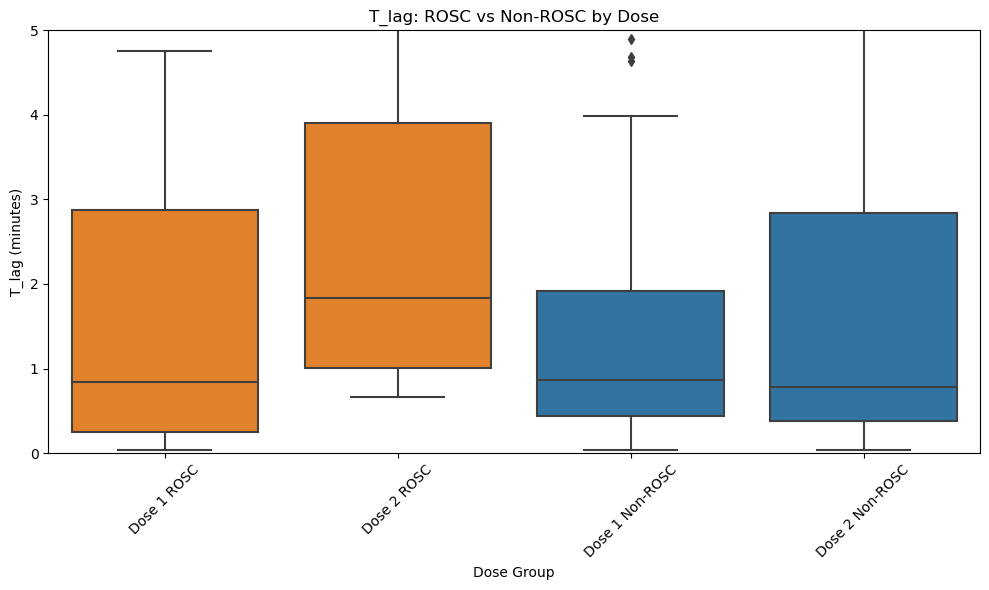

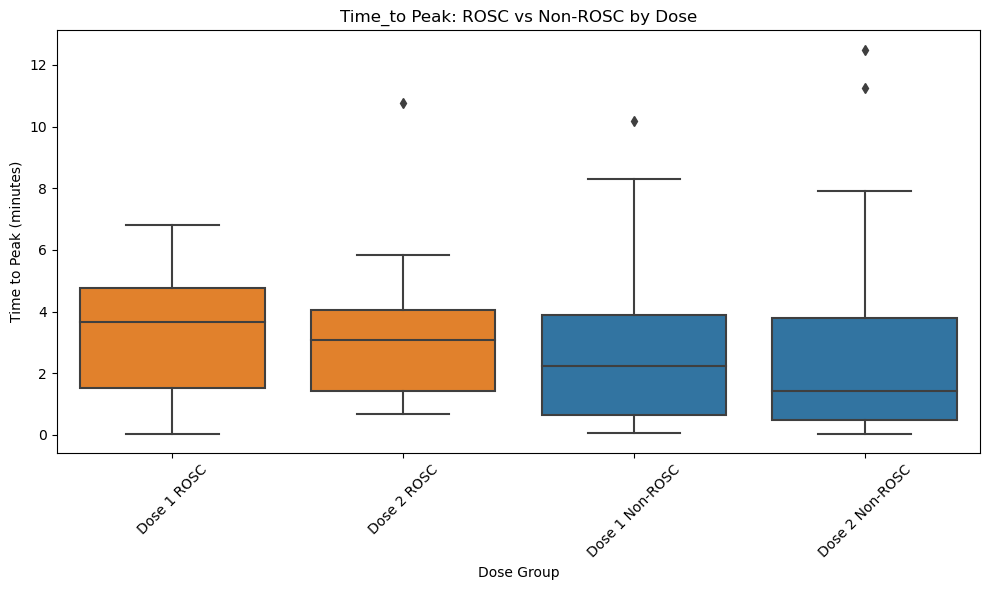

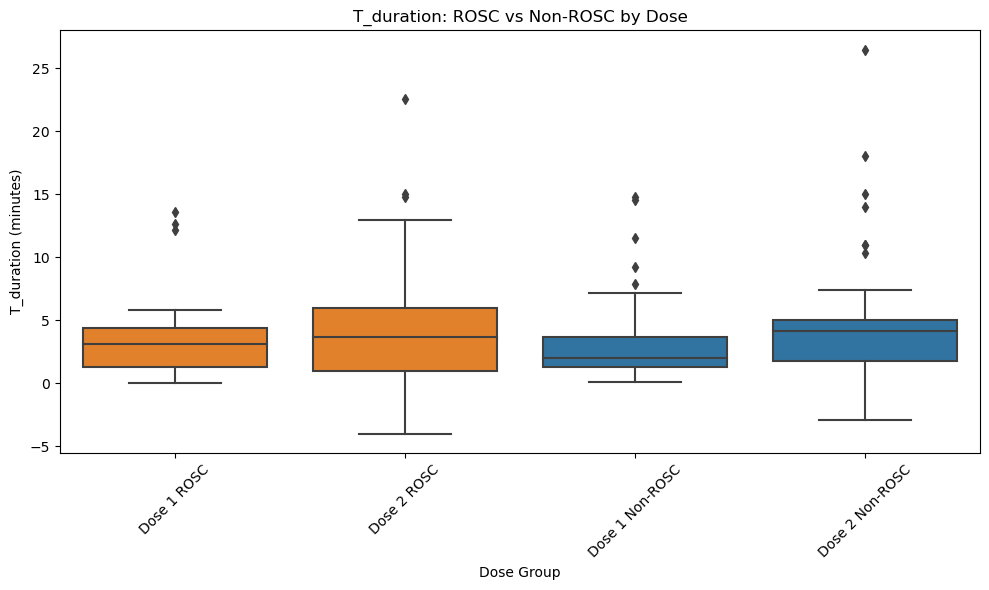

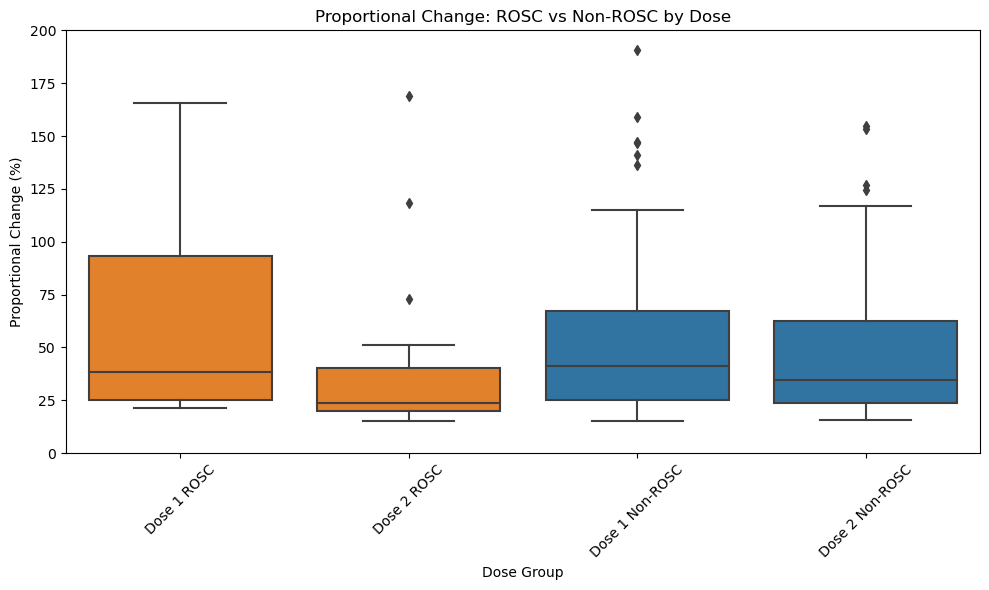

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results data
results = pd.read_excel('etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi333.xlsx')

# Prepare data for box plotting by creating separate columns for each dose's metrics
rosc_data = pd.DataFrame({
    'Dose_Group': ['Dose 1 ROSC'] * len(results[results['rosc'] == 1]) + ['Dose 2 ROSC'] * len(results[results['rosc'] == 1]),
    'T_lag': list(results[results['rosc'] == 1]['t_lag_1']) + list(results[results['rosc'] == 1]['t_lag_2']),
    'Time_to_Peak': list(results[results['rosc'] == 1]['time_to_peak_1']) + list(results[results['rosc'] == 1]['time_to_peak_2']),
    'T_duration': list(results[results['rosc'] == 1]['t_duration_1']) + list(results[results['rosc'] == 1]['t_duration_2']),
    'Proportional_Change': list(results[results['rosc'] == 1]['proportional_change_1']) + list(results[results['rosc'] == 1]['proportional_change_2'])
})

non_rosc_data = pd.DataFrame({
    'Dose_Group': ['Dose 1 Non-ROSC'] * len(results[results['rosc'] == 0]) + ['Dose 2 Non-ROSC'] * len(results[results['rosc'] == 0]),
    'T_lag': list(results[results['rosc'] == 0]['t_lag_1']) + list(results[results['rosc'] == 0]['t_lag_2']),
    'Time_to_Peak': list(results[results['rosc'] == 0]['time_to_peak_1']) + list(results[results['rosc'] == 0]['time_to_peak_2']),
    'T_duration': list(results[results['rosc'] == 0]['t_duration_1']) + list(results[results['rosc'] == 0]['t_duration_2']),
    'Proportional_Change': list(results[results['rosc'] == 0]['proportional_change_1']) + list(results[results['rosc'] == 0]['proportional_change_2'])
})

# Combine ROSC and Non-ROSC data
results_doses = pd.concat([rosc_data, non_rosc_data], ignore_index=True)

# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each metric
metrics = ['T_lag', 'Time_to_Peak', 'T_duration', 'Proportional_Change']
results_doses_cleaned = results_doses.copy()

# Define custom color palette using default blue and orange
custom_palette = {
    'Dose 1 ROSC': 'tab:orange',
    'Dose 2 ROSC': 'tab:orange',
    'Dose 1 Non-ROSC': 'tab:blue',
    'Dose 2 Non-ROSC': 'tab:blue'
}

# Box plots for each metric across doses after outlier removal
titles = {
    'T_lag': 'T_lag: ROSC vs Non-ROSC by Dose',
    'Time_to_Peak': 'Time_to Peak: ROSC vs Non-ROSC by Dose',
    'T_duration': 'T_duration: ROSC vs Non-ROSC by Dose',
    'Proportional_Change': 'Proportional Change: ROSC vs Non-ROSC by Dose'
}
y_labels = {
    'T_lag': 'T_lag (minutes)',
    'Time_to_Peak': 'Time to Peak (minutes)',
    'T_duration': 'T_duration (minutes)',
    'Proportional_Change': 'Proportional Change (%)'
}

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Dose_Group', y=metric, data=results_doses_cleaned, palette=custom_palette)
    plt.title(titles[metric])
    plt.xlabel('Dose Group')
    plt.ylabel(y_labels[metric])
    plt.xticks(rotation=45)
    
    if metric == 'Proportional_Change':  # Set y-axis limit for Proportional Change
        plt.ylim(0, 200)
    if metric == 'T_lag':  # Set y-axis limit for Proportional Change
        plt.ylim(0, 5)
    plt.tight_layout()
    plt.show()


## Multiple epi individual plots with 2 epi

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data files
df_cases = pd.read_excel('Multi_Epi_Cases_Full.xlsx')
df_analysis = pd.read_excel('etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi2222.xlsx')

# Merge the data on 'patientId'
df = df_cases.merge(df_analysis[['patientId', 'rosc', 'epi_time_1', 't_lag_1', 't_duration_1', 'time_to_peak_1',
                                 'peak_etco2_1', 'proportional_change_1', 'epi_time_2', 't_lag_2', 
                                 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2']],
                    on='patientId', how='left')

# Convert time columns to datetime
df['start'] = pd.to_datetime(df['start'], errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], errors='coerce')

# Create the directory for saving plots if it doesn’t exist
output_folder = 'ETCO2_Plots_Multiple_Epi_Patients222'
os.makedirs(output_folder, exist_ok=True)


# Iterate over each patient in the results
for _, row in results.iterrows():
    patient_id = row['patientId']
    
    # Filter ETCO₂ data for this patient, showing 3 minutes before the first epinephrine event onward
    group = df[(df['patientId'] == patient_id) & (df['start'] >= row['epi_time_1'] - pd.Timedelta(minutes=3))]
    
    # Determine color based on ROSC or Non-ROSC
    color = 'green' if row['rosc'] == 1 else 'blue'
    
    # Plot the ETCO₂ trend for the patient
    plt.figure(figsize=(12, 6))
    plt.plot(group['start'], group['etco2'], label='ETCO₂', color=color, marker='o')
    
    # Plot markers for the first epinephrine event
    plt.axvline(x=row['epi_time_1'], color='red', linestyle='--', label='Epinephrine 1', lw=2)
    
    if pd.notna(row['t_lag_1']):
        t_lag_1_time = row['epi_time_1'] + pd.Timedelta(minutes=row['t_lag_1'])
        plt.axvline(x=t_lag_1_time, color='purple', linestyle='-.', label='T_lag 1', lw=2)

    if pd.notna(row['t_duration_1']):
        t_duration_1_end = t_lag_1_time + pd.Timedelta(minutes=row['t_duration_1'])
        plt.axvline(x=t_duration_1_end, color='blue', linestyle='-.', label='T_duration 1', lw=2)

    if pd.notna(row['time_to_peak_1']):
        t_peak_1_time = row['epi_time_1'] + pd.Timedelta(minutes=row['time_to_peak_1'])
        plt.axvline(x=t_peak_1_time, color='green', linestyle='--', label='T_peak 1', lw=2)

    # Plot markers for the second epinephrine event, if available
    if pd.notna(row['epi_time_2']):
        plt.axvline(x=row['epi_time_2'], color='red', linestyle='--', label='Epinephrine 2', lw=2, alpha=0.6)

        if pd.notna(row['t_lag_2']):
            t_lag_2_time = row['epi_time_2'] + pd.Timedelta(minutes=row['t_lag_2'])
            plt.axvline(x=t_lag_2_time, color='purple', linestyle='-.', label='T_lag 2', lw=2, alpha=0.6)

        if pd.notna(row['t_duration_2']):
            t_duration_2_end = t_lag_2_time + pd.Timedelta(minutes=row['t_duration_2'])
            plt.axvline(x=t_duration_2_end, color='blue', linestyle='-.', label='T_duration 2', lw=2, alpha=0.6)

        if pd.notna(row['time_to_peak_2']):
            t_peak_2_time = row['epi_time_2'] + pd.Timedelta(minutes=row['time_to_peak_2'])
            plt.axvline(x=t_peak_2_time, color='green', linestyle='--', label='T_peak 2', lw=2, alpha=0.6)

    # Set plot details
    plt.title(f'Patient {patient_id} - ETCO₂ Trend ({"ROSC" if row["rosc"] == 1 else "Non-ROSC"})')
    plt.xlabel('Time')
    plt.ylabel('ETCO₂ Value')
    
    # Format the x-axis to show time in HH:MM
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Save the plot in the appropriate folder
    subfolder = 'ROSC' if row['rosc'] == 1 else 'Non_ROSC'
    patient_plot_folder = os.path.join(output_folder, subfolder)
    if not os.path.exists(patient_plot_folder):
        os.makedirs(patient_plot_folder)

    plot_filename = os.path.join(patient_plot_folder, f'Patient_{patient_id}_ETCO2_Trend.png')
    plt.savefig(plot_filename)
    plt.close()

print(f"Patient ETCO₂ trend plots saved in {output_folder}")

Patient ETCO₂ trend plots saved in ETCO2_Plots_Multiple_Epi_Patients222


## multiple plots with 3 epi

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# Load the data files
df_cases = pd.read_excel('Multi_Epi_Cases_Full.xlsx')
df_analysis = pd.read_excel('etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi333.xlsx')

# Merge the data on 'patientId'
df = df_cases.merge(df_analysis[['patientId', 'rosc', 'epi_time_1', 't_lag_1', 't_duration_1', 'time_to_peak_1',
                                 'peak_etco2_1', 'proportional_change_1', 'epi_time_2', 't_lag_2', 
                                 't_duration_2', 'time_to_peak_2', 'peak_etco2_2', 'proportional_change_2',
                                 'epi_time_3']],
                    on='patientId', how='left')

# Convert time columns to datetime
df['start'] = pd.to_datetime(df['start'], errors='coerce')
df['epi_time'] = pd.to_datetime(df['epi_time'], errors='coerce')

# Create the directory for saving plots if it doesn’t exist
output_folder = 'ETCO2_Plots_Multiple_Epi_Patients333'
os.makedirs(output_folder, exist_ok=True)

# Iterate over each patient in the results
for _, row in df_analysis.iterrows():
    patient_id = row['patientId']
    
    # Filter ETCO₂ data for this patient, showing 3 minutes before the first epinephrine event onward
    group = df[(df['patientId'] == patient_id) & (df['start'] >= row['epi_time_1'] - pd.Timedelta(minutes=3))]
    
    # Determine color based on ROSC or Non-ROSC
    color = 'green' if row['rosc'] == 1 else 'blue'
    
    # Plot the ETCO₂ trend for the patient
    plt.figure(figsize=(12, 6))
    plt.plot(group['start'], group['etco2'], label='ETCO₂', color=color, marker='o')
    
    # Plot markers for the first epinephrine event
    plt.axvline(x=row['epi_time_1'], color='red', linestyle='--', label='Epinephrine 1', lw=2)
    
    if pd.notna(row['t_lag_1']):
        t_lag_1_time = row['epi_time_1'] + pd.Timedelta(minutes=row['t_lag_1'])
        plt.axvline(x=t_lag_1_time, color='purple', linestyle='-.', label='T_lag 1', lw=2)

    if pd.notna(row['t_duration_1']):
        t_duration_1_end = t_lag_1_time + pd.Timedelta(minutes=row['t_duration_1'])
        plt.axvline(x=t_duration_1_end, color='blue', linestyle='-.', label='T_duration 1', lw=2)

    if pd.notna(row['time_to_peak_1']):
        t_peak_1_time = row['epi_time_1'] + pd.Timedelta(minutes=row['time_to_peak_1'])
        plt.axvline(x=t_peak_1_time, color='green', linestyle='--', label='T_peak 1', lw=2)

    # Plot markers for the second epinephrine event, if available
    if pd.notna(row['epi_time_2']):
        plt.axvline(x=row['epi_time_2'], color='red', linestyle='--', label='Epinephrine 2', lw=2, alpha=0.6)

        if pd.notna(row['t_lag_2']):
            t_lag_2_time = row['epi_time_2'] + pd.Timedelta(minutes=row['t_lag_2'])
            plt.axvline(x=t_lag_2_time, color='purple', linestyle='-.', label='T_lag 2', lw=2, alpha=0.6)

        if pd.notna(row['t_duration_2']):
            t_duration_2_end = t_lag_2_time + pd.Timedelta(minutes=row['t_duration_2'])
            plt.axvline(x=t_duration_2_end, color='blue', linestyle='-.', label='T_duration 2', lw=2, alpha=0.6)

        if pd.notna(row['time_to_peak_2']):
            t_peak_2_time = row['epi_time_2'] + pd.Timedelta(minutes=row['time_to_peak_2'])
            plt.axvline(x=t_peak_2_time, color='green', linestyle='--', label='T_peak 2', lw=2, alpha=0.6)

    # Plot marker only for the third epinephrine event, if available
    if pd.notna(row['epi_time_3']):
        plt.axvline(x=row['epi_time_3'], color='deeppink', linestyle='--', label='Epinephrine 3', lw=2, alpha=0.7)

    # Set plot details
    plt.title(f'Patient {patient_id} - ETCO₂ Trend ({"ROSC" if row["rosc"] == 1 else "Non-ROSC"})')
    plt.xlabel('Time')
    plt.ylabel('ETCO₂ Value')
    
    # Format the x-axis to show time in HH:MM
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Save the plot in the appropriate folder
    subfolder = 'ROSC' if row['rosc'] == 1 else 'Non_ROSC'
    patient_plot_folder = os.path.join(output_folder, subfolder)
    if not os.path.exists(patient_plot_folder):
        os.makedirs(patient_plot_folder)

    plot_filename = os.path.join(patient_plot_folder, f'Patient_{patient_id}_ETCO2_Trend.png')
    plt.savefig(plot_filename)
    plt.close()

print(f"Patient ETCO₂ trend plots saved in {output_folder}")


Patient ETCO₂ trend plots saved in ETCO2_Plots_Multiple_Epi_Patients333


## Significant Difference

In [21]:
import pandas as pd
from scipy.stats import wilcoxon

# Load the input data file
file_path = 'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi333.xlsx'
df = pd.read_excel(file_path)

# Select only the necessary columns for Dose 1 and Dose 2 proportional change
df_clean = df[['proportional_change_1', 'proportional_change_2']].dropna()  # Drop rows with NaN values

# Run Wilcoxon Signed-Rank Test on the proportional change of Dose 1 vs Dose 2
stat, p_value = wilcoxon(df_clean['proportional_change_1'], df_clean['proportional_change_2'])

# Display results
wilcoxon_results = {
    "Statistic": stat,
    "p-value": p_value,
    "Significance": "Significant difference" if p_value < 0.05 else "No significant difference"
}

wilcoxon_results


{'Statistic': 2066.0,
 'p-value': 0.04406938638010449,
 'Significance': 'Significant difference'}

In [22]:
import pandas as pd
from scipy.stats import wilcoxon

# Load the input data file
file_path = 'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi333.xlsx'
df = pd.read_excel(file_path)

# Define a function to perform Wilcoxon Signed-Rank Test for a specified pair of columns
def run_wilcoxon_test(df, column1, column2):
    df_clean = df[[column1, column2]].dropna()  # Drop rows with NaN values for the selected columns
    stat, p_value = wilcoxon(df_clean[column1], df_clean[column2])
    return {
        "Statistic": stat,
        "p-value": p_value,
        "Significance": "Significant difference" if p_value < 0.05 else "No significant difference"
    }

# Run Wilcoxon Signed-Rank Test on t_lag, time_to_peak, and t_duration for Dose 1 vs Dose 2
results = {
    "Proportional Change": run_wilcoxon_test(df, 'proportional_change_1', 'proportional_change_2'),
    "T_lag": run_wilcoxon_test(df, 't_lag_1', 't_lag_2'),
    "Time_to_Peak": run_wilcoxon_test(df, 'time_to_peak_1', 'time_to_peak_2'),
    "T_duration": run_wilcoxon_test(df, 't_duration_1', 't_duration_2')
}

results


{'Proportional Change': {'Statistic': 2066.0,
  'p-value': 0.04406938638010449,
  'Significance': 'Significant difference'},
 'T_lag': {'Statistic': 3079.5,
  'p-value': 0.3877732747426892,
  'Significance': 'No significant difference'},
 'Time_to_Peak': {'Statistic': 2181.5,
  'p-value': 0.1819638506670288,
  'Significance': 'No significant difference'},
 'T_duration': {'Statistic': 2483.0,
  'p-value': 0.048031774960888944,
  'Significance': 'Significant difference'}}

Interpretation:
A statistically significant difference between the effects of Dose 1 and Dose 2 suggests that the change in ETCO₂ following the first dose is meaningfully different from the change following the second dose for the patients in your study. This could imply that Dose 1 and Dose 2 have different levels of effectiveness in terms of how they impact ETCO₂ levels.

To interpret practically:

If the mean or median proportional change for Dose 1 is higher, you might conclude that Dose 1 tends to have a greater effect on ETCO₂ than Dose 2.

In [4]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Load the input data file
file_path = 'etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi333.xlsx'
df = pd.read_excel(file_path)

# Filter data for ROSC and Non-ROSC groups
rosc_data = df[df['rosc'] == 1]
non_rosc_data = df[df['rosc'] == 0]

# Initialize dictionary to store results
metrics = ['t_lag_2', 't_duration_2', 'time_to_peak_2','proportional_change_2']
results = {}

# Run Mann-Whitney U test for each metric
for metric in metrics:
    if metric in rosc_data.columns and metric in non_rosc_data.columns:
        # Drop NaN values for the test
        rosc_values = rosc_data[metric].dropna()
        non_rosc_values = non_rosc_data[metric].dropna()
        
        # Perform the Mann-Whitney U test
        stat, p_value = mannwhitneyu(rosc_values, non_rosc_values, alternative='two-sided')
        
        # Save the results
        results[metric] = {
            "Statistic": stat,
            "p-value": p_value,
            "Significance": "Significant difference" if p_value < 0.05 else "No significant difference"
        }

# Display results
for metric, result in results.items():
    print(f"{metric}: {result}")


t_lag_2: {'Statistic': 1721.0, 'p-value': 0.002028149923392036, 'Significance': 'Significant difference'}
t_duration_2: {'Statistic': 1308.0, 'p-value': 0.5845350806081281, 'Significance': 'No significant difference'}
time_to_peak_2: {'Statistic': 1246.0, 'p-value': 0.03691024627214182, 'Significance': 'Significant difference'}
proportional_change_2: {'Statistic': 677.0, 'p-value': 0.03894753630999538, 'Significance': 'Significant difference'}


## Time Difference

In [3]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

# Load the data
df = pd.read_excel('etco2_tlag_tpeak_tduration_proportional_change_analysis_multiple_epi_filtered.xlsx', sheet_name="Sheet1")

# Calculate the time difference in minutes between epi_time_1 and epi_time_2
df['time_difference'] = (df['epi_time_2'] - df['epi_time_1']).dt.total_seconds() / 60

# Separate ROSC and non-ROSC groups
rosc_group = df[df['rosc'] == 1]['time_difference']
non_rosc_group = df[df['rosc'] == 0]['time_difference']

# Calculate the average time difference for each group
rosc_avg_diff = rosc_group.mean()
non_rosc_avg_diff = non_rosc_group.mean()

print(f"Average Time Difference for ROSC group: {rosc_avg_diff:.2f} minutes")
print(f"Average Time Difference for Non-ROSC group: {non_rosc_avg_diff:.2f} minutes")

# Set significance level
alpha = 0.05

# Perform a statistical test to compare the average time differences
# Using t-test if normal distribution assumption is met, otherwise Mann-Whitney U test
# Here we assume non-parametric since the sample sizes are different and distribution is unknown
stat, p_value = mannwhitneyu(rosc_group.dropna(), non_rosc_group.dropna(), alternative='two-sided')

print("\nMann-Whitney U Test Results:")
print(f"U-statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the test result
if p_value < alpha:
    print("Result: Reject the null hypothesis. There is a significant difference between the average time difference for ROSC and Non-ROSC groups.")
else:
    print("Result: Fail to reject the null hypothesis. No significant difference between the average time difference for ROSC and Non-ROSC groups.")


Average Time Difference for ROSC group: 5.88 minutes
Average Time Difference for Non-ROSC group: 6.48 minutes

Mann-Whitney U Test Results:
U-statistic: 1294.0
P-value: 0.6337257763790631
Result: Fail to reject the null hypothesis. No significant difference between the average time difference for ROSC and Non-ROSC groups.
